In [1]:
%matplotlib inline
import pandas as pd
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import matplotlib
import axelrod as axl
import imp
import csv
import os

assert pd.__version__ == "0.20.2"
assert np.__version__ == '1.12.1'
assert axl.__version__ == '2.13.0'
assert matplotlib.__version__ == "2.0.2"

import players


abbreviations = imp.load_source('abbreviations', '../src/abbreviations.py')
from abbreviations import abbreviations
def abbreviate(player_name, abbreviations=abbreviations):
    """
    Return the abbreviated name of a play if one has been given
    """
    if isinstance(player_name, axl.Player):
        player_name = str(player_name)
    return abbreviations.get(player_name, player_name)

player_names = [abbreviate(str(p)) for p in  players.players]
number_of_digits = 3  # Number of digits to round for LaTeX tables

turns = 200
number_of_players = len(player_names)

assert number_of_players == 176




assert abbreviate("Tit For Tat") == "TfT"
assert abbreviate("Random: 0.5") == "Random: 0.5"
assert abbreviate(axl.TitForTat()) == "TfT"

with open("./reference_keys.csv", "r") as f:
    reader = csv.reader(f)
    reference_keys = {player: eval(keys) for player, keys in reader}
    
assert reference_keys['ALLCorALLD'] == ['axelrodproject']
assert reference_keys['Cooperator'] == ['Axelrod1984', 'Mittal2009', 'Press2012']

def clean_latex(string):
    """Replace some special carachters"""
    string = string.replace("textbackslashpi", "pi")
    string = string.replace("textbackslashphi", "phi")
    string = string.replace("\\$", "$")
    string = string.replace("\\$", "$")
    string = string.replace("\\textasciicircum", "^")
    string = string.replace("\_", "_")
    string = string.replace("2_2_2", "2\_2\_2")
    string = string.replace("1_1_1", "1\_1\_1")
    string = string.replace("\{", "{")
    string = string.replace("\}", "}")
    return string

# Write player appendix

In [2]:
with open("../assets/list_of_players.tex", "w") as f:
    for player in sorted(players.players, key=str):
        latex_name = "{}".format(player).replace("_", "\_")
        f.write("\item {}".format(latex_name))
        abbreviation = abbreviate(player)
        # Only write true abbreviations:
        if abbreviation != player.name and abbreviation != str(player) and ("$^{*}$" not in abbreviation):
            f.write(" (\\textbf{{{}}})".format(abbreviation))
        if player.classifier["stochastic"]:
            f.write(" - \\textit{Stochastic}")
        else:
            f.write(" - \\textit{Deterministic}")
        try:
            mem = int(player.classifier["memory_depth"])
        except OverflowError:
            mem = "\(\infty\)"
        f.write(" - \\textit{{Memory depth}}: {}".format(mem))
        try:
            f.write(". \cite{{{}}}\n".format(", ".join(sorted(reference_keys[str(player)]))))
        except KeyError:
            f.write(".\n")

## Number of players

In [3]:
number_of_players = len(players.players)
number_of_stochastic_players = len([p for p in players.players if p.classifier["stochastic"]])

with open("../assets/number_of_players.tex", "w") as f:
    f.write(str(number_of_players))
    
with open("../assets/number_of_stochastic_players.tex", "w") as f:
    f.write(str(number_of_stochastic_players))

# Study the standard tournaments

## Scores

In [4]:
def read_scores(files):
    dfs = []
    for gz in files:
        if "scores" in gz:
            dfs.append(pd.read_csv(gz, header=None, names=player_names))
    df = pd.concat(dfs)
    df /= turns * (number_of_players - 1)  # Scale all scores
    return df

In [5]:
standard_files = glob.glob("./data/*_0_1000*gz")
standard_scores = read_scores(files=standard_files)

In [6]:
with open("../assets/standard_number_of_repetitions.tex", "w") as f:
    f.write(str(len(standard_scores.index)))

In [7]:
def summarise_scores(scores):
    df = scores.describe(percentiles=[0.05, .25, .5, .75, .95]).transpose()
    df = df.sort_values("50%", ascending=False)  # Sorted on the median
    df.drop('count', axis=1, inplace=True)
    return df

standard_score_summary = summarise_scores(standard_scores)
standard_score_summary.head(15)

mean       std       min        5%  \
EvolvedLookerUp2_2_2$^{*}$     2.955000  0.010284  2.915286  2.937171   
Evolved HMM 5$^{*}$            2.954391  0.013955  2.902600  2.931284   
Evolved FSM 16$^{*}$           2.952336  0.013229  2.900371  2.929657   
PSO Gambler 2_2_2$^{*}$        2.938483  0.013268  2.884400  2.913657   
Evolved FSM 16 Noise 05$^{*}$  2.919016  0.012534  2.873800  2.898170   
PSO Gambler 1_1_1$^{*}$        2.912007  0.023363  2.805486  2.873513   
Evolved ANN 5$^{*}$            2.911650  0.010203  2.870857  2.894229   
Evolved FSM 4$^{*}$            2.909608  0.012098  2.867486  2.889114   
Evolved ANN$^{*}$              2.907216  0.010017  2.865229  2.890229   
PSO Gambler Mem1$^{*}$         2.901039  0.025433  2.782943  2.858486   
Evolved ANN 5 Noise 05$^{*}$   2.864222  0.008264  2.830314  2.850200   
DBS                            2.857108  0.008898  2.822743  2.842429   
Winner12                       2.849331  0.008066  2.820000  2.835686   
Fool Me Once                   2.843958  0.008172  2.817914  2.830486   
Omega TFT: 3, 8                2.840909  0.011311  2.800257  2.822057   

                                    25%       50%       75%       95%  \
EvolvedLookerUp2_2_2$^{*}$     2.948143  2.955514  2.962514  2.970829   
Evolved HMM 5$^{*}$            2.944686  2.954457  2.964057  2.977200   
Evolved FSM 16$^{*}$           2.943371  2.952943  2.961886  2.973086   
PSO Gambler 2_2_2$^{*}$        2.930057  2.940200  2.948457  2.957314   
Evolved FSM 16 Noise 05$^{*}$  2.910457  2.919057  2.927686  2.939457   
PSO Gambler 1_1_1$^{*}$        2.896257  2.912200  2.927857  2.950171   
Evolved ANN 5$^{*}$            2.904657  2.911914  2.919200  2.927686   
Evolved FSM 4$^{*}$            2.901114  2.910229  2.918457  2.928600   
Evolved ANN$^{*}$              2.900486  2.907514  2.914429  2.923086   
PSO Gambler Mem1$^{*}$         2.883743  2.901314  2.918600  2.942429   
Evolved ANN 5 Noise 05$^{*}$   2.858371  2.864600  2.870371  2.877114   
DBS                            2.850914  2.857171  2.863343  2.871600   
Winner12                       2.843514  2.849743  2.855314  2.861914   
Fool Me Once                   2.838000  2.844286  2.849657  2.857171   
Omega TFT: 3, 8                2.833114  2.841029  2.848800  2.859343   

                                    max  
EvolvedLookerUp2_2_2$^{*}$     2.989400  
Evolved HMM 5$^{*}$            3.007400  
Evolved FSM 16$^{*}$           2.993171  
PSO Gambler 2_2_2$^{*}$        2.972400  
Evolved FSM 16 Noise 05$^{*}$  2.965429  
PSO Gambler 1_1_1$^{*}$        3.011857  
Evolved ANN 5$^{*}$            2.944543  
Evolved FSM 4$^{*}$            2.942629  
Evolved ANN$^{*}$              2.941629  
PSO Gambler Mem1$^{*}$         2.994429  
Evolved ANN 5 Noise 05$^{*}$   2.890943  
DBS                            2.899371  
Winner12                       2.873743  
Fool Me Once                   2.881943  
Omega TFT: 3, 8                2.882143

In [8]:
# Write the top 15 players to a tex table
with open("../assets/standard_top_15_scores_summary.tex", "w") as f:
    f.write(clean_latex(standard_score_summary.head(15).round(number_of_digits).to_latex()))

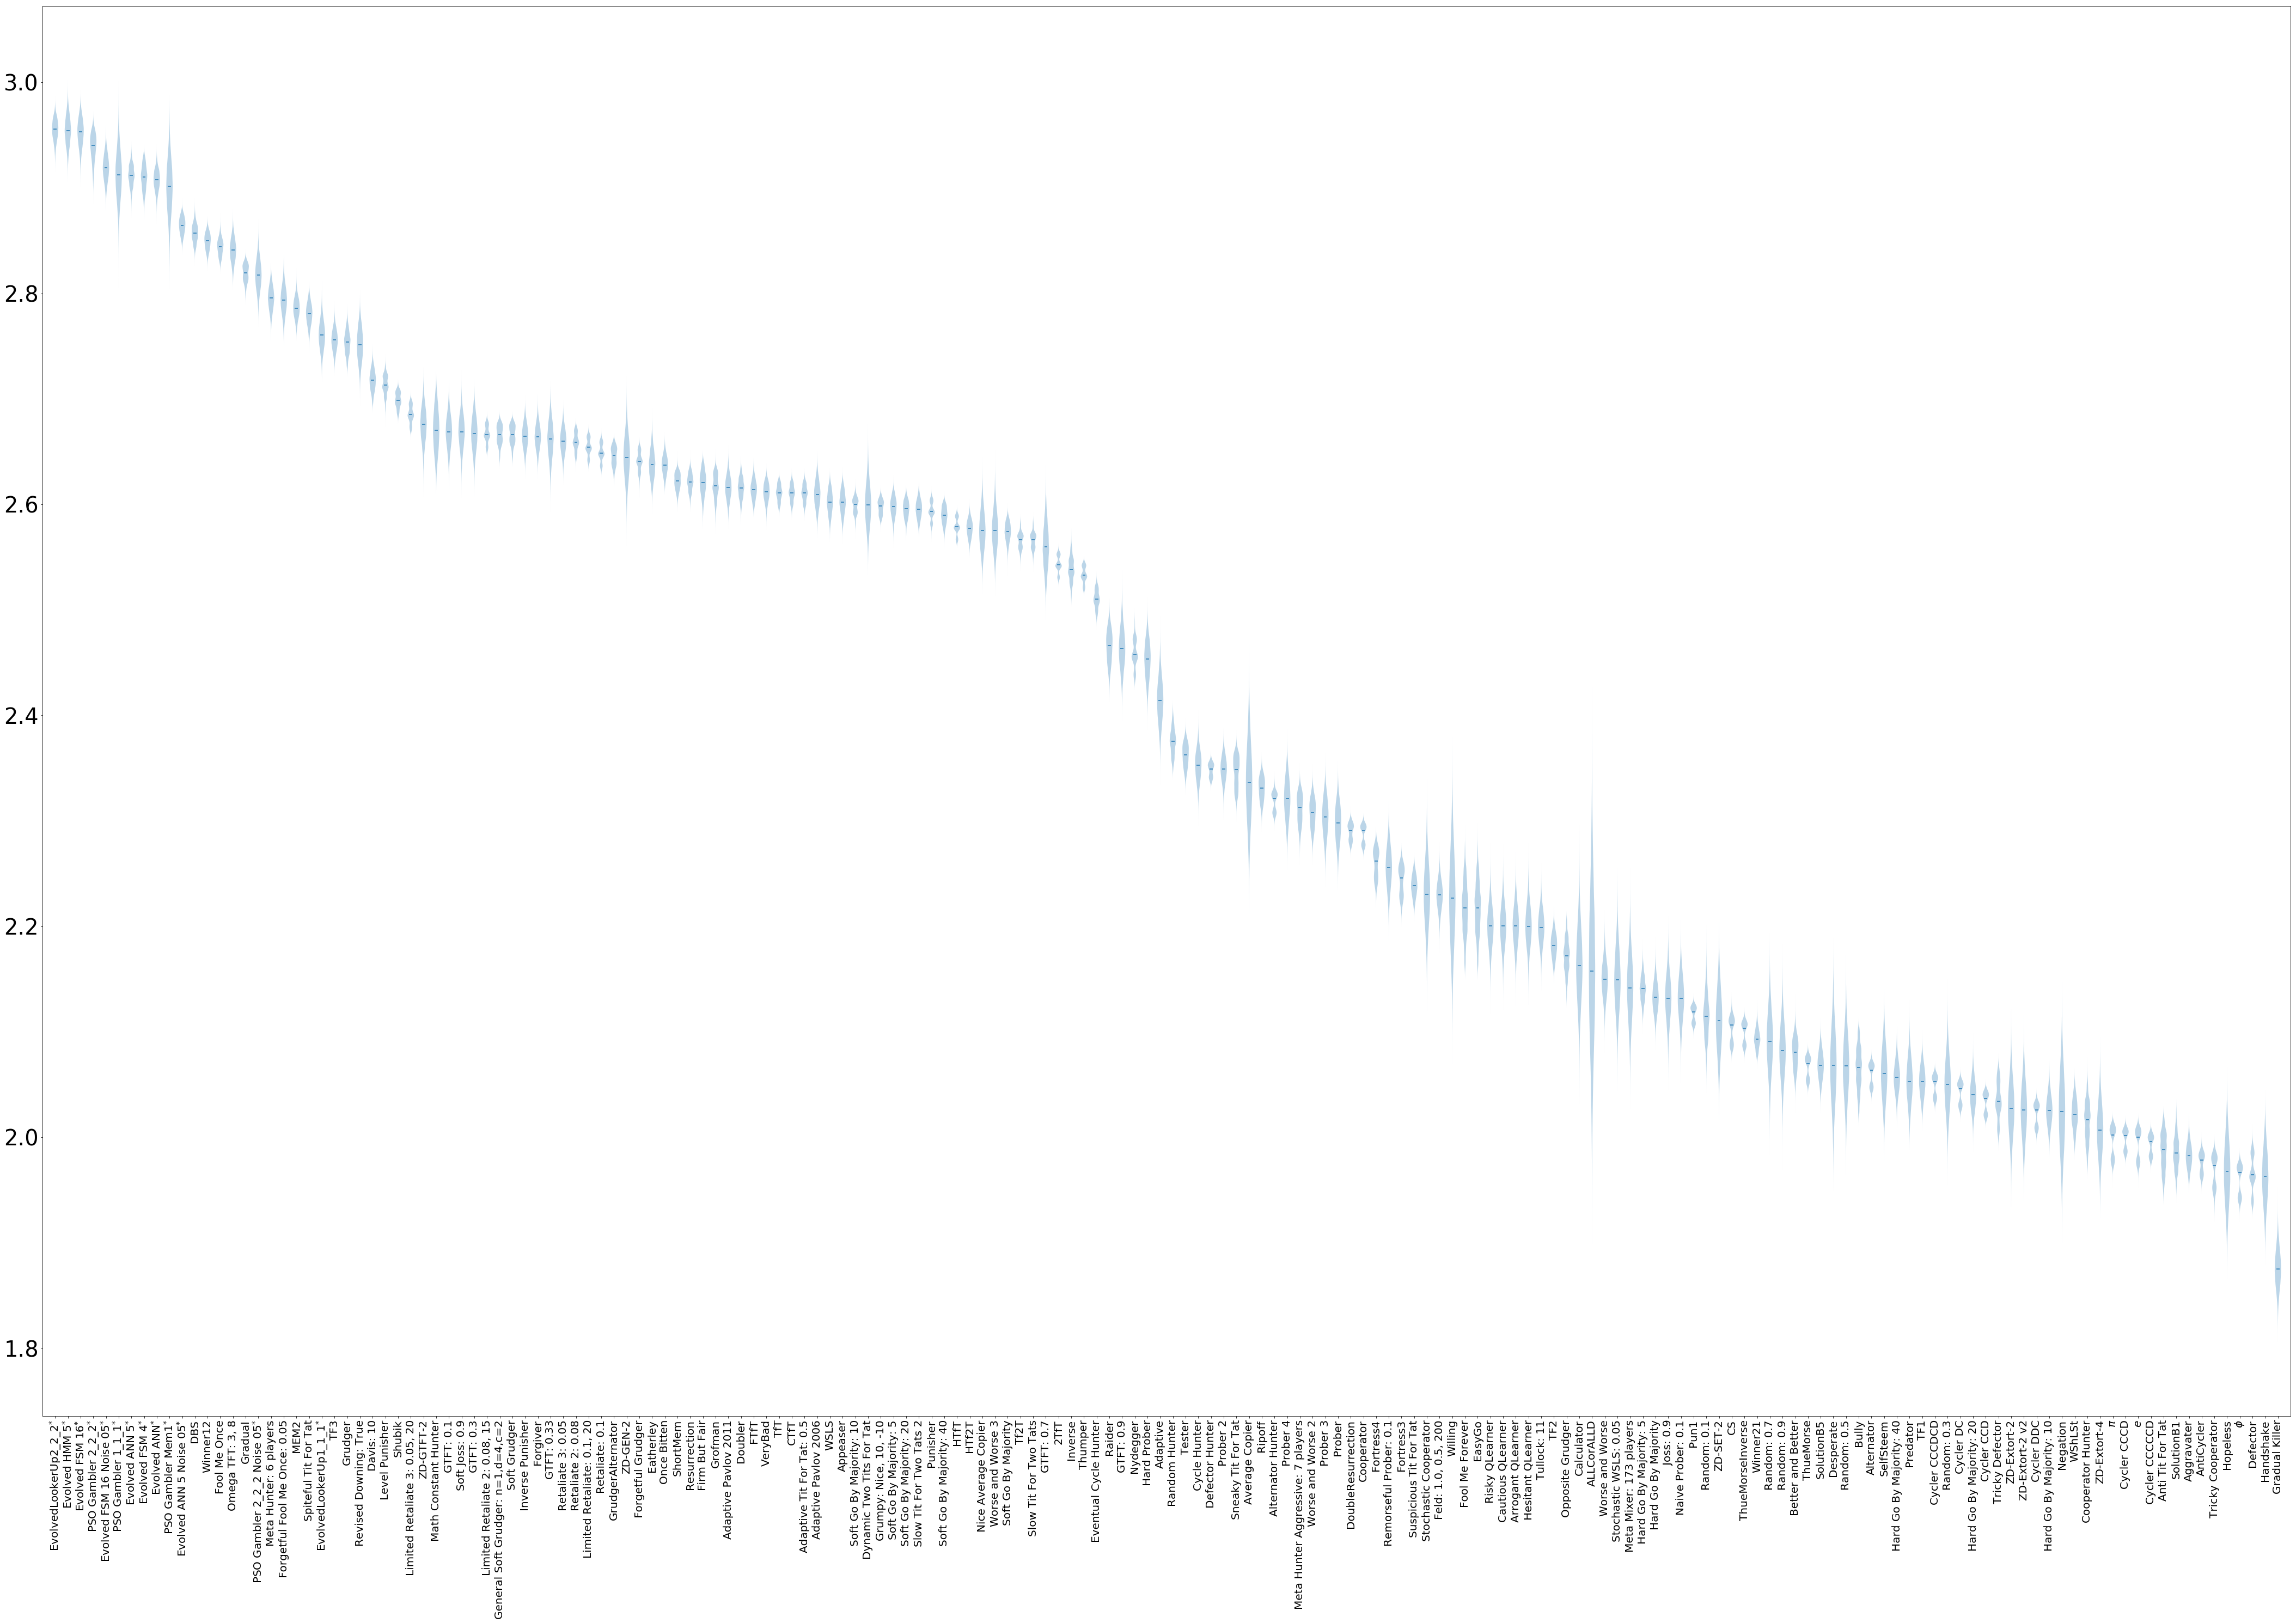

In [9]:
def violon_plot(scores, summary, filename):
    fig, ax = plt.subplots() 
    width = number_of_players / 3
    height = width / 1.414
    spacing = 4 
    positions = spacing * np.arange(1, number_of_players + 1, 1)
    fig.set_size_inches(width, height) 

    ax.violinplot([scores[player] for player in summary.index],
                  positions=positions, widths=spacing / 2,
                  showmedians=True, showextrema=False)
    ax.set_xticks(positions) 
    ax.set_xticklabels(summary.index, rotation=90)
    ax.set_xlim([0, spacing * (number_of_players + 1)])
    ax.tick_params(axis='x', which='both', labelsize=20)
    ax.tick_params(axis='y', which='both', labelsize=40)
    fig.tight_layout()
    fig.savefig(filename);
    
violon_plot(standard_scores, standard_score_summary, "../assets/standard_scores_boxplots.pdf")

## Ranks

Every row corresponds to a tournament. We can see the ranks of each strategy across the tournament repetitions.

In [10]:
def summarise_ranks(scores):
    df = scores.rank(axis=1, ascending=False).describe(percentiles=[0.05, .25, .5, .75, .95]).transpose()
    df = df.sort_values("mean")
    for var in ["min", "max"]:
        df[var] = df[var].astype(int)
    df.drop('count', axis=1, inplace=True)
    return df

standard_rank_summary = summarise_ranks(standard_scores)
standard_rank_summary.head(15)

mean       std  min    5%   25%   50%  \
EvolvedLookerUp2_2_2$^{*}$      2.17318  1.069786    1   1.0   1.0   2.0   
Evolved HMM 5$^{*}$             2.32110  1.274636    1   1.0   1.0   2.0   
Evolved FSM 16$^{*}$            2.48906  1.299451    1   1.0   1.0   2.0   
PSO Gambler 2_2_2$^{*}$         3.96108  1.524937    1   2.0   3.0   4.0   
Evolved FSM 16 Noise 05$^{*}$   6.30037  1.687827    1   4.0   5.0   6.0   
PSO Gambler 1_1_1$^{*}$         7.08206  2.498588    1   3.0   5.0   7.0   
Evolved ANN 5$^{*}$             7.28746  1.522913    2   5.0   6.0   7.0   
Evolved FSM 4$^{*}$             7.52678  1.631222    2   5.0   6.0   8.0   
Evolved ANN$^{*}$               7.90067  1.450435    2   5.0   7.0   8.0   
PSO Gambler Mem1$^{*}$          8.22160  2.535236    1   4.0   6.0   9.0   
Evolved ANN 5 Noise 05$^{*}$   11.36223  0.872215    8  10.0  11.0  11.0   
DBS                            12.19665  1.125375    9  11.0  11.0  12.0   
Winner12                       13.22087  1.136911    9  11.0  12.0  13.0   
Fool Me Once                   13.95971  1.082966    9  12.0  13.0  14.0   
Omega TFT: 3, 8                14.27546  1.301252    9  12.0  13.0  15.0   

                                75%   95%  max  
EvolvedLookerUp2_2_2$^{*}$      3.0   4.0    8  
Evolved HMM 5$^{*}$             3.0   5.0   10  
Evolved FSM 16$^{*}$            3.0   5.0   10  
PSO Gambler 2_2_2$^{*}$         5.0   7.0   10  
Evolved FSM 16 Noise 05$^{*}$   7.0   9.0   11  
PSO Gambler 1_1_1$^{*}$         9.0  10.0   17  
Evolved ANN 5$^{*}$             8.0  10.0   11  
Evolved FSM 4$^{*}$             9.0  10.0   12  
Evolved ANN$^{*}$               9.0  10.0   12  
PSO Gambler Mem1$^{*}$         10.0  12.0   20  
Evolved ANN 5 Noise 05$^{*}$   12.0  13.0   16  
DBS                            13.0  14.0   16  
Winner12                       14.0  15.0   17  
Fool Me Once                   15.0  15.0   17  
Omega TFT: 3, 8                15.0  16.0   19

In [11]:
# Write the top 15 players to a tex table
with open("../assets/standard_top_15_ranks_summary.tex", "w") as f:
    f.write(clean_latex(standard_rank_summary.head(15).round(number_of_digits).to_latex()))

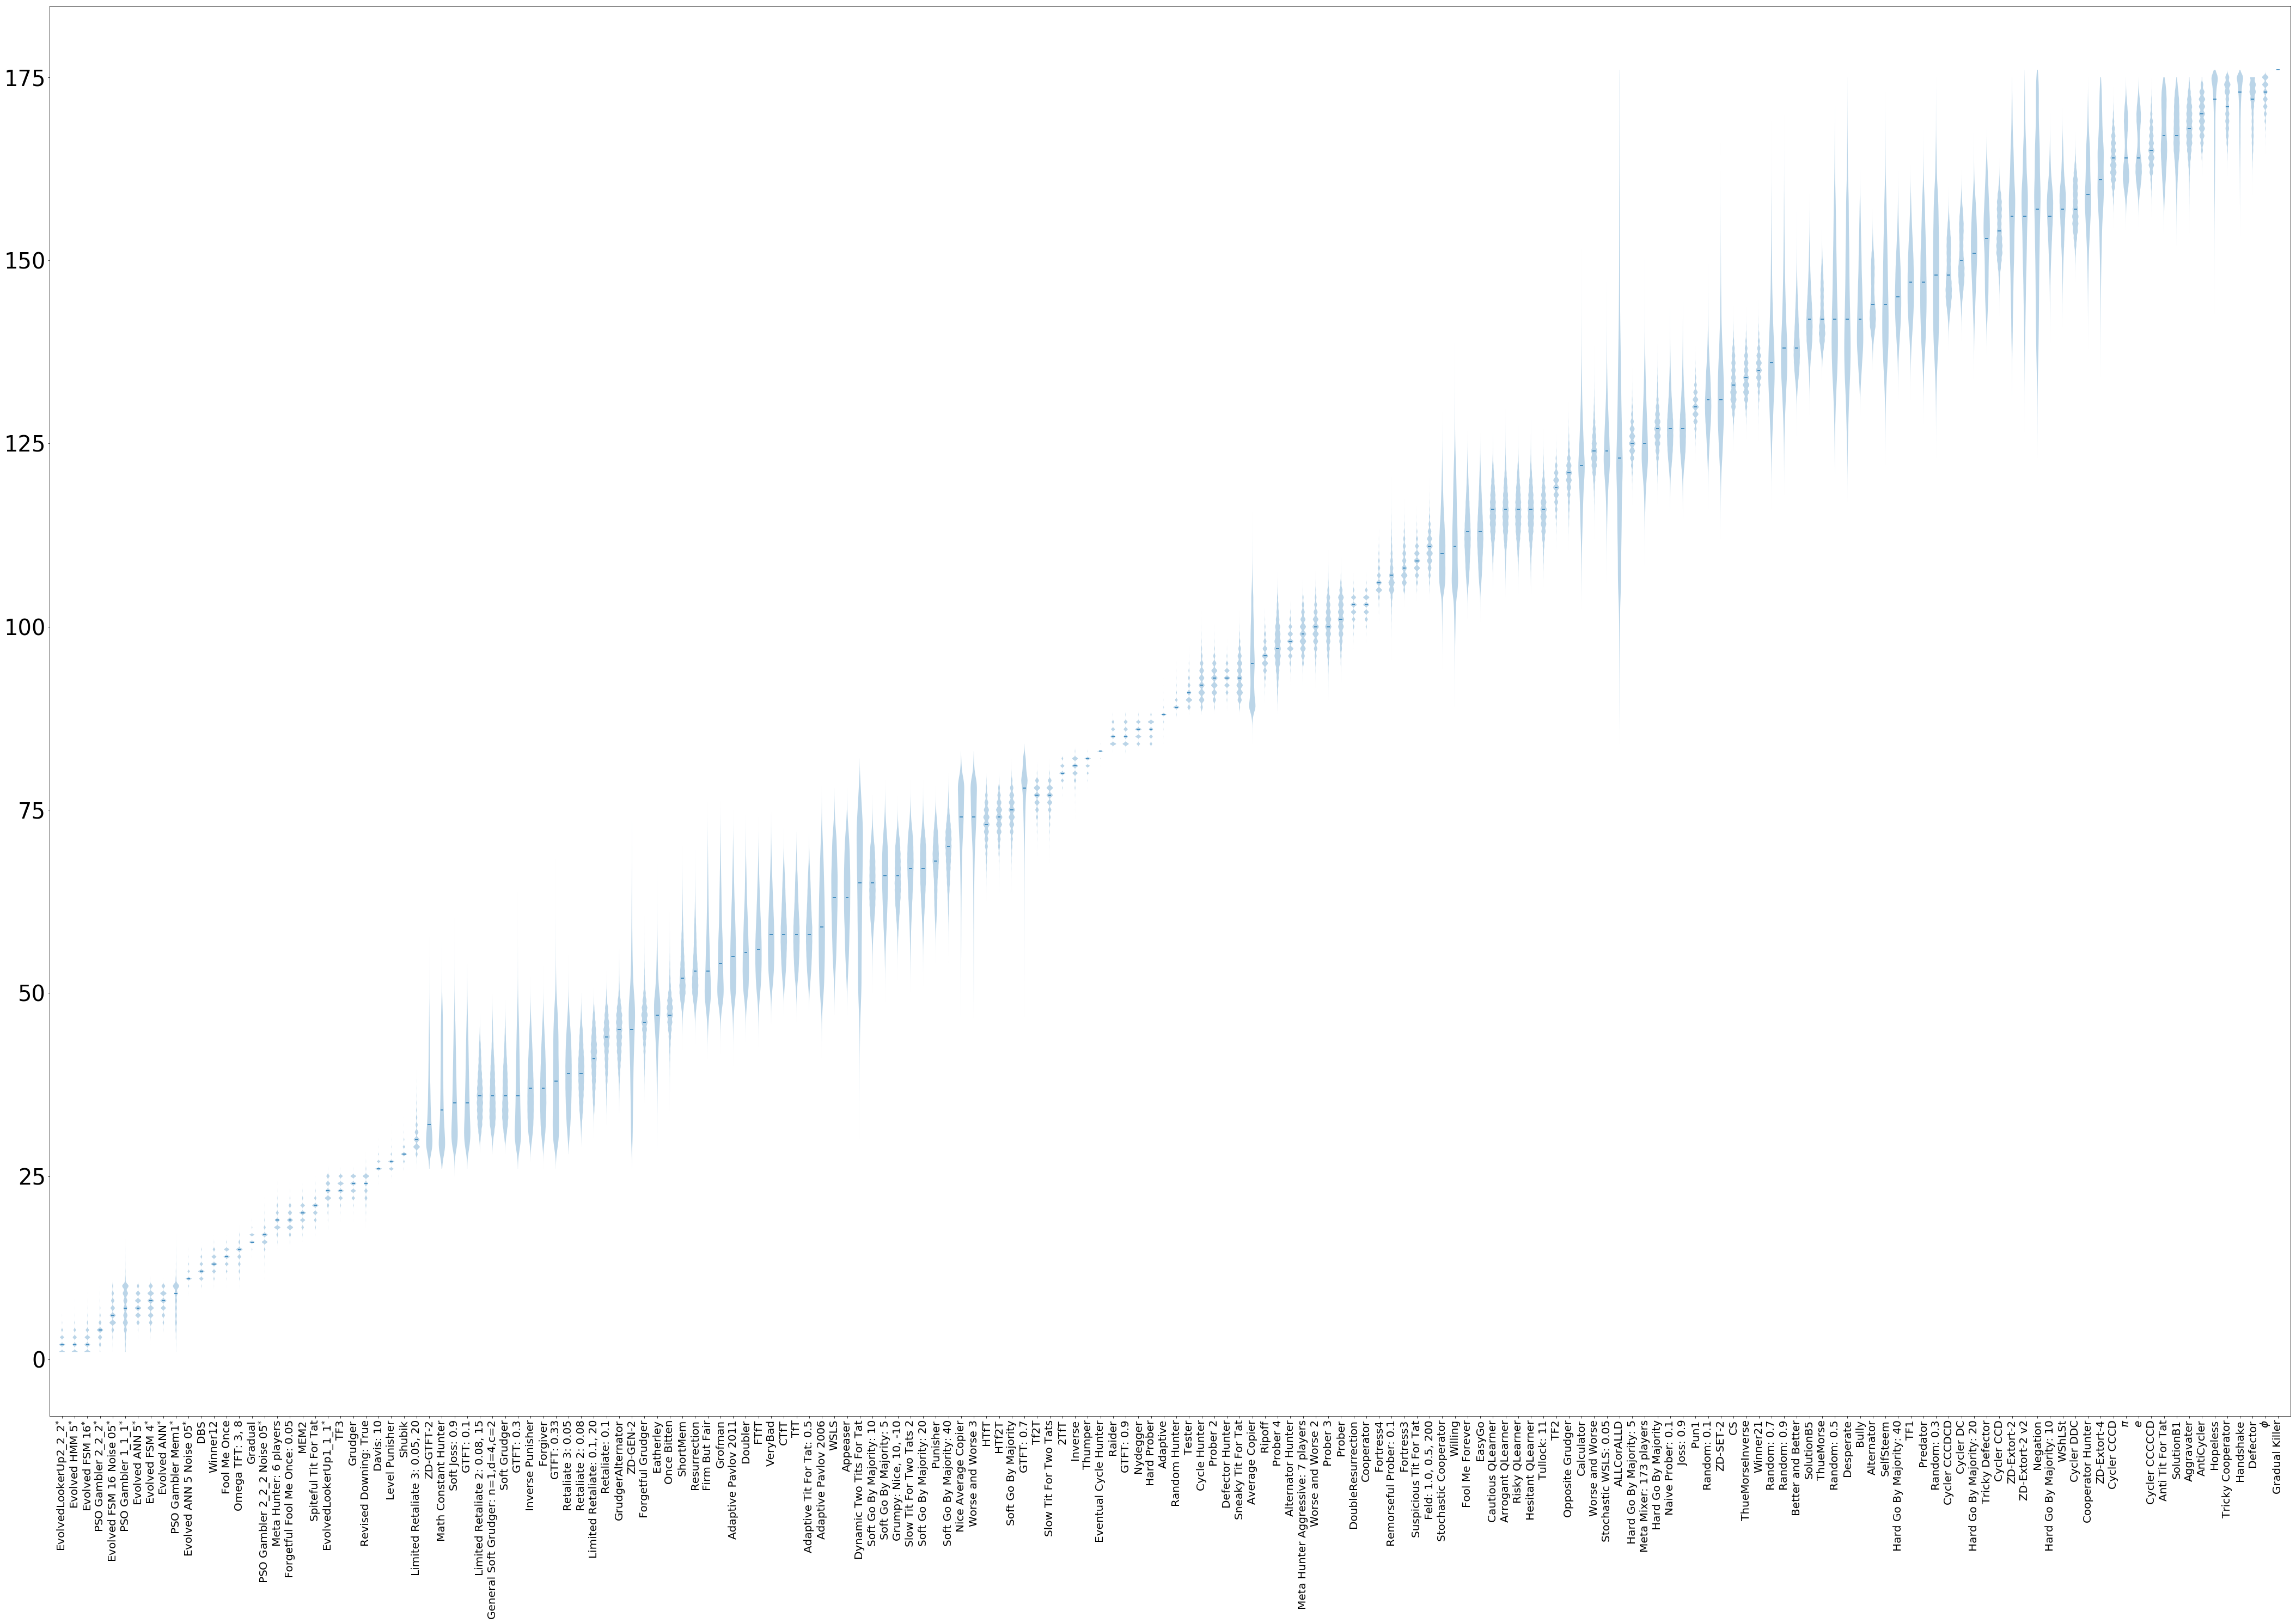

In [12]:
violon_plot(standard_scores.rank(axis=1, ascending=False), standard_rank_summary, "../assets/standard_ranks_boxplots.pdf")

## Payoff matrix

As all the individual payoff matrix files have the mean values and they all have the same number of repetitions, the mean of the means is the mean over all tournaments.

In [13]:
def read_payoff_matrix(files):
    arrays = []
    for gz in files:
        if "payoff_matrix" in gz:
            arrays.append(np.array(pd.read_csv(gz, header=None)))  # Read through pd to deal with float conversion
    return sum(arrays) / len(arrays)

In [14]:
standard_payoff_matrix = read_payoff_matrix(files=standard_files)
assert standard_payoff_matrix.shape == (176, 176)

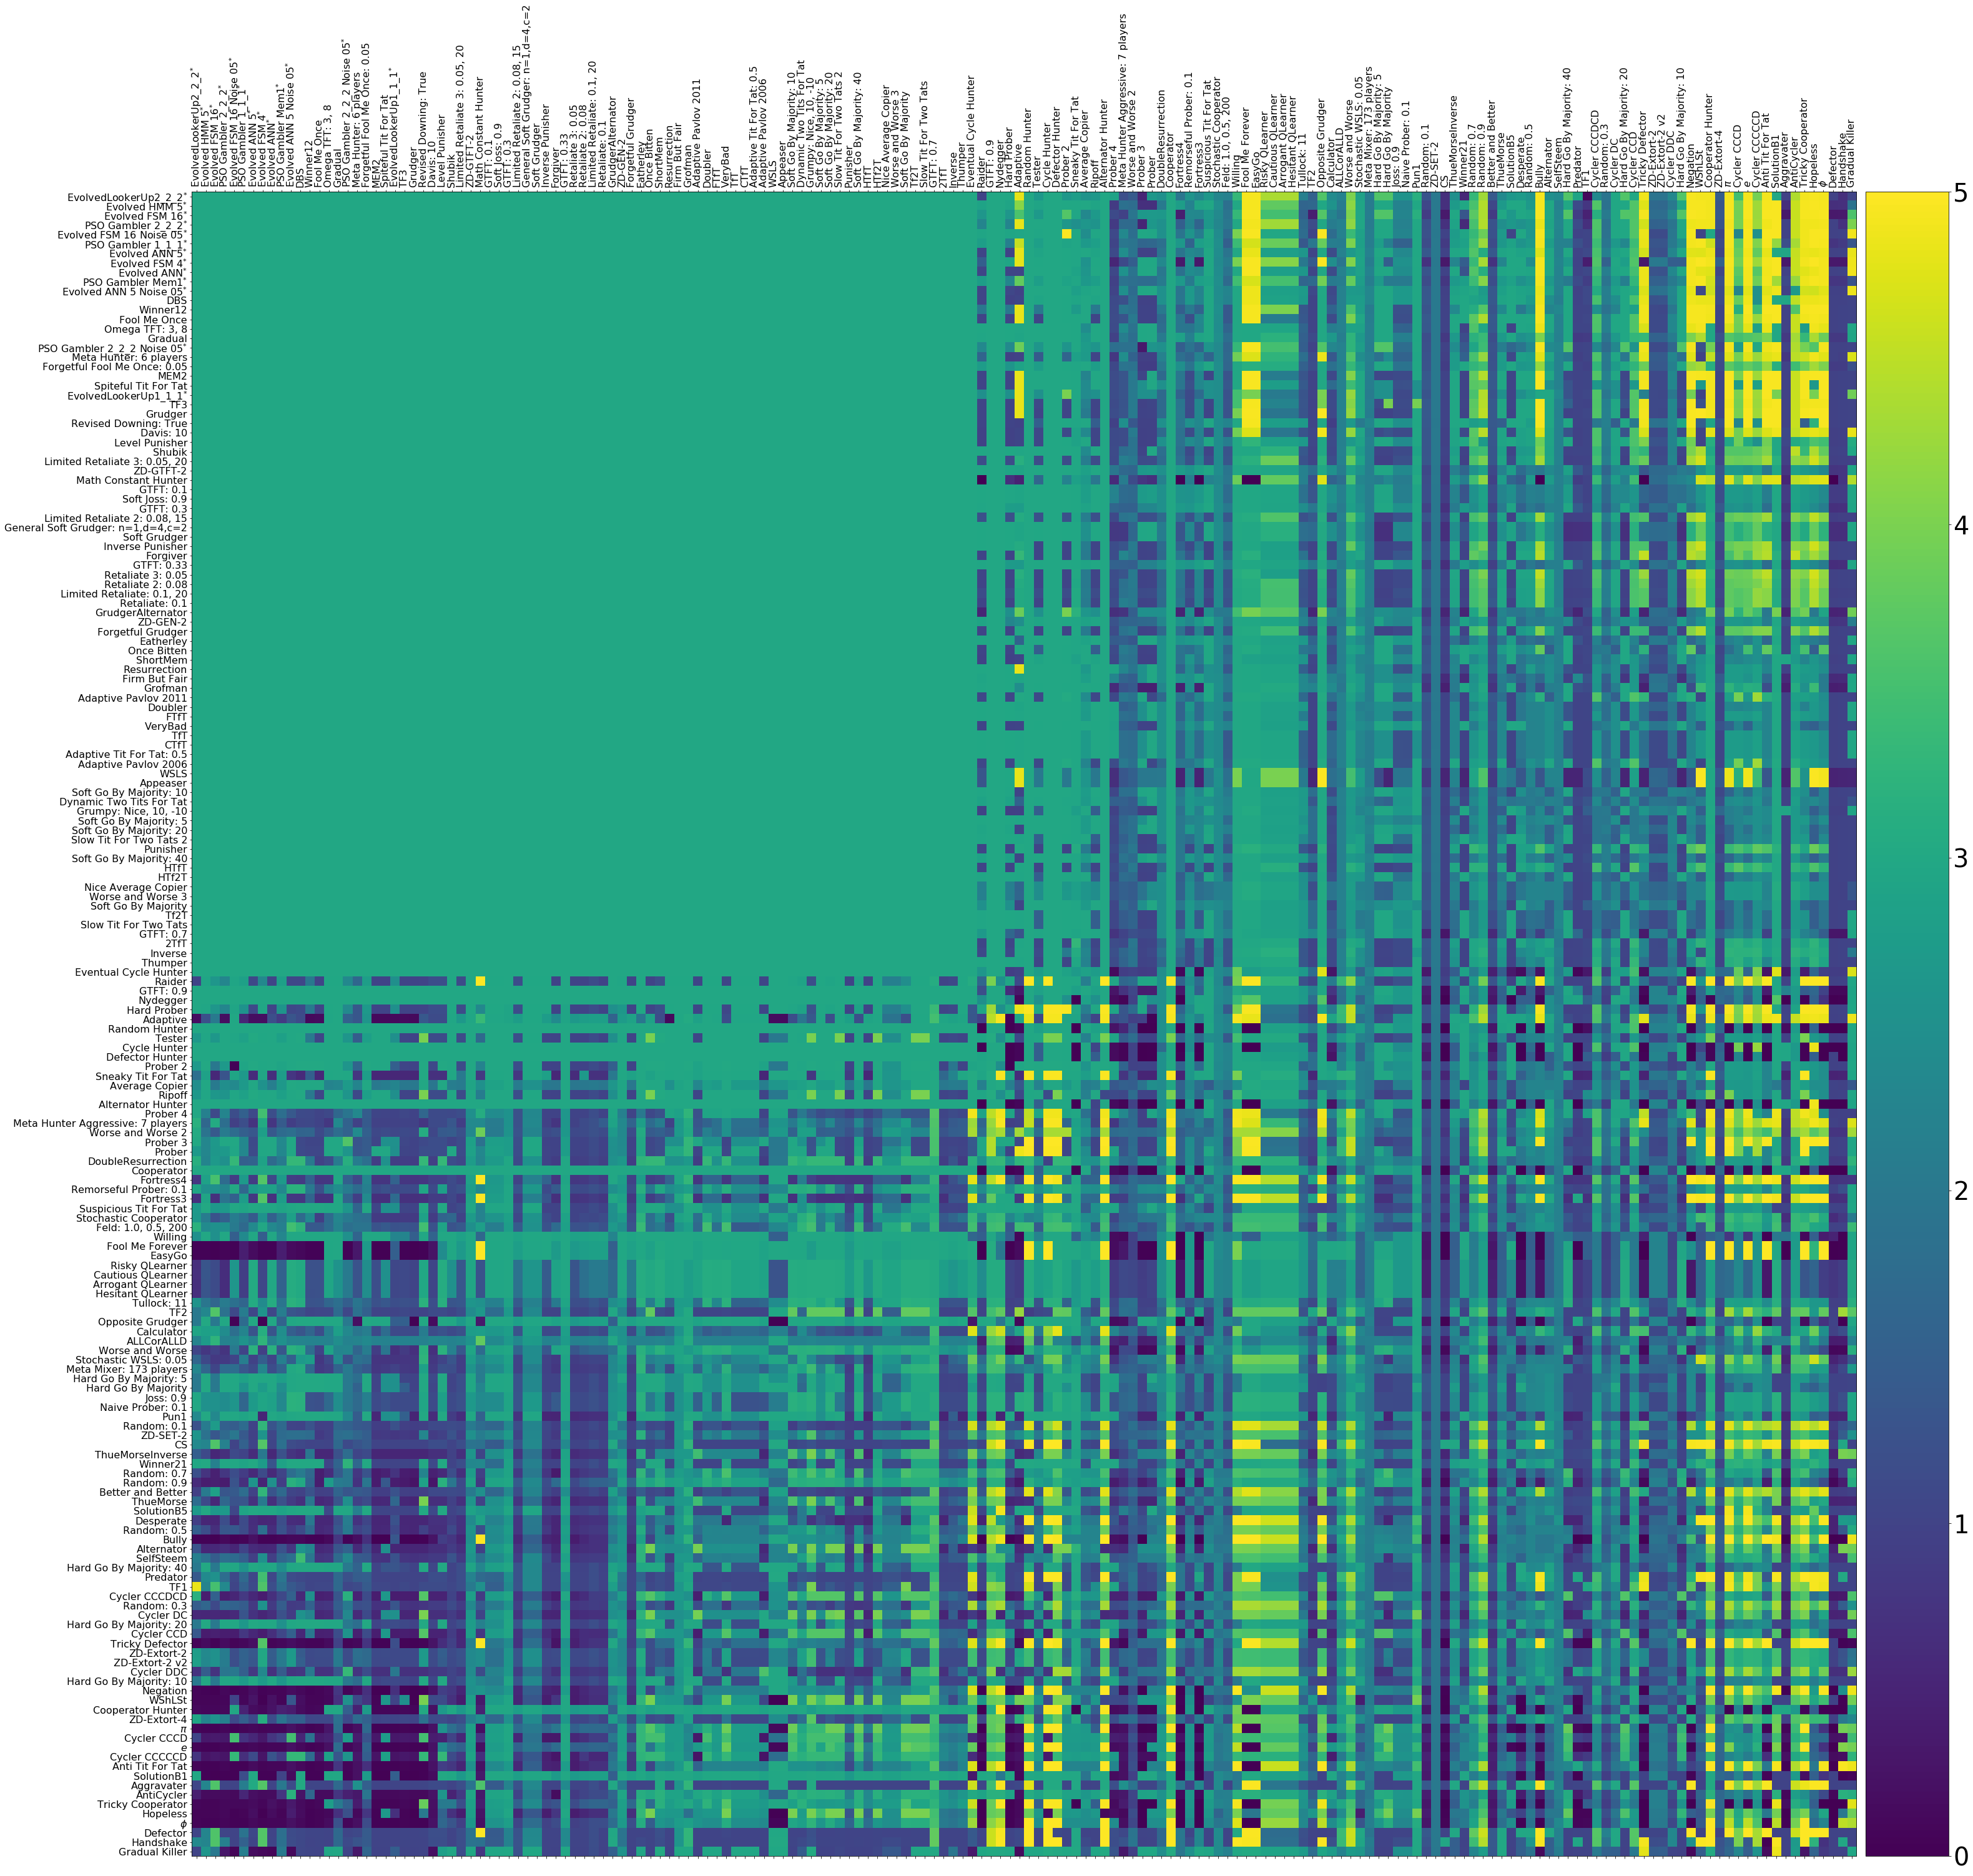

In [15]:
def payoff_heatmap(matrix, player_names, filename):
    fig, ax = plt.subplots()
    width = number_of_players / 4
    height = width
    spacing = 4 
    fig.set_size_inches(width, height) 

    mat = ax.matshow(matrix)

    ax.set_xticks(range(number_of_players))
    ax.set_yticks(range(number_of_players))
    ax.set_xticklabels(player_names, rotation=90)
    ax.set_yticklabels(player_names)
    ax.tick_params(axis='both', which='both', labelsize=16) 

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    cax.tick_params(labelsize=40) 
    fig.colorbar(mat, cax=cax)

    fig.tight_layout()
    fig.savefig(filename);
    
standard_ranked_player_names = list(standard_score_summary.index)
standard_ranked_indices = [player_names.index(name) for name in standard_ranked_player_names]
standard_ranked_payoff_matrix = standard_payoff_matrix[standard_ranked_indices][:, standard_ranked_indices]

for i, _ in enumerate(player_names):  # Check that ordering has been done correctly
    assert standard_payoff_matrix[i, i] == standard_ranked_payoff_matrix[standard_ranked_indices.index(i), 
                                                                         standard_ranked_indices.index(i)]

payoff_heatmap(standard_ranked_payoff_matrix, standard_ranked_player_names, "../assets/standard_scores_heatmap.pdf")

## Head to head wins

In [16]:
def read_wins(files):
    dfs = []
    for gz in files:
        if "wins" in gz:
            dfs.append(pd.read_csv(gz, header=None, names=player_names))
    df = pd.concat(dfs)
    return df

In [17]:
standard_wins = read_wins(files=standard_files)

In [18]:
def summarise_wins(wins, score_summary):
    df = wins.describe(percentiles=[0.05, .25, .5, .75, .95]).transpose()
    df = df.sort_values("50%", ascending=False)  # Sorted on the median
    for var in ["min", "max"]:
        df[var] = df[var].astype(int)
    df.drop('count', axis=1, inplace=True)
    return df.loc[score_summary.index]

standard_win_summary = summarise_wins(standard_wins, standard_score_summary)
standard_win_summary.head(15)

mean       std  min    5%   25%   50%  \
EvolvedLookerUp2_2_2$^{*}$     48.25920  1.335624   43  46.0  47.0  48.0   
Evolved HMM 5$^{*}$            41.35790  1.220540   36  39.0  41.0  41.0   
Evolved FSM 16$^{*}$           56.97848  1.098891   51  55.0  56.0  57.0   
PSO Gambler 2_2_2$^{*}$        40.69160  1.089382   36  39.0  40.0  41.0   
Evolved FSM 16 Noise 05$^{*}$  40.06954  1.672973   34  37.0  39.0  40.0   
PSO Gambler 1_1_1$^{*}$        45.00520  1.595363   38  42.0  44.0  45.0   
Evolved ANN 5$^{*}$            43.22380  0.674272   41  42.0  43.0  43.0   
Evolved FSM 4$^{*}$            37.22666  0.951306   34  36.0  37.0  37.0   
Evolved ANN$^{*}$              43.09980  1.020618   40  42.0  42.0  43.0   
PSO Gambler Mem1$^{*}$         43.44400  1.836935   34  40.0  42.0  43.0   
Evolved ANN 5 Noise 05$^{*}$   33.71106  1.125166   30  32.0  33.0  34.0   
DBS                            32.32928  1.197866   28  30.0  32.0  32.0   
Winner12                       40.17920  1.037472   36  39.0  39.0  40.0   
Fool Me Once                   50.12052  0.422230   48  50.0  50.0  50.0   
Omega TFT: 3, 8                35.15670  0.859488   32  34.0  35.0  35.0   

                                75%   95%  max  
EvolvedLookerUp2_2_2$^{*}$     49.0  50.0   53  
Evolved HMM 5$^{*}$            42.0  43.0   45  
Evolved FSM 16$^{*}$           58.0  59.0   60  
PSO Gambler 2_2_2$^{*}$        41.0  42.0   45  
Evolved FSM 16 Noise 05$^{*}$  41.0  43.0   47  
PSO Gambler 1_1_1$^{*}$        46.0  48.0   51  
Evolved ANN 5$^{*}$            44.0  44.0   47  
Evolved FSM 4$^{*}$            38.0  39.0   41  
Evolved ANN$^{*}$              44.0  45.0   48  
PSO Gambler Mem1$^{*}$         45.0  46.0   51  
Evolved ANN 5 Noise 05$^{*}$   34.0  35.0   38  
DBS                            33.0  34.0   38  
Winner12                       41.0  42.0   44  
Fool Me Once                   50.0  51.0   52  
Omega TFT: 3, 8                36.0  37.0   39

In [19]:
standard_win_summary.sort_values("50%", ascending=False).head(15)

mean       std  min     5%    25%    50%    75%  \
Aggravater           161.59464  0.862101  160  160.0  161.0  162.0  162.0   
Defector             161.60478  0.864012  160  160.0  161.0  162.0  162.0   
CS                   159.64554  1.005365  155  158.0  159.0  160.0  160.0   
ZD-Extort-4          150.59816  2.661771  138  146.0  149.0  151.0  152.0   
Handshake            149.55164  1.754273  142  147.0  148.0  150.0  151.0   
ZD-Extort-2          146.09384  3.444629  129  140.0  144.0  146.0  148.0   
ZD-Extort-2 v2       146.29074  3.424874  131  141.0  144.0  146.0  149.0   
Winner21             139.94624  1.225112  136  138.0  139.0  140.0  141.0   
TF2                  138.24004  1.699753  130  135.0  137.0  138.0  139.0   
TF1                  135.69170  1.407882  130  133.0  135.0  136.0  137.0   
Naive Prober: 0.1    136.01620  2.503953  127  132.0  134.0  136.0  138.0   
Feld: 1.0, 0.5, 200  136.08686  1.695928  130  133.0  135.0  136.0  137.0   
Joss: 0.9            136.01520  2.502873  126  132.0  134.0  136.0  138.0   
Predator             133.71776  1.385301  129  131.0  133.0  134.0  135.0   
SolutionB5           125.84270  1.508722  120  123.0  125.0  126.0  127.0   

                       95%  max  
Aggravater           163.0  163  
Defector             163.0  163  
CS                   161.0  161  
ZD-Extort-4          155.0  162  
Handshake            152.0  154  
ZD-Extort-2          152.0  160  
ZD-Extort-2 v2       152.0  160  
Winner21             142.0  143  
TF2                  141.0  143  
TF1                  138.0  140  
Naive Prober: 0.1    140.0  147  
Feld: 1.0, 0.5, 200  139.0  144  
Joss: 0.9            140.0  146  
Predator             136.0  138  
SolutionB5           128.0  131

In [20]:
# Write the top 15 players to a tex table
with open("../assets/standard_top_15_wins_summary.tex", "w") as f:
    f.write(clean_latex(standard_win_summary.head(15).round(number_of_digits).to_latex()))

In [21]:
# Write the top 15 winning players to a tex table
with open("../assets/standard_top_15_winners_wins_summary.tex", "w") as f:
    f.write(clean_latex(standard_win_summary.sort_values("50%", ascending=False).head(15).round(number_of_digits).to_latex()))

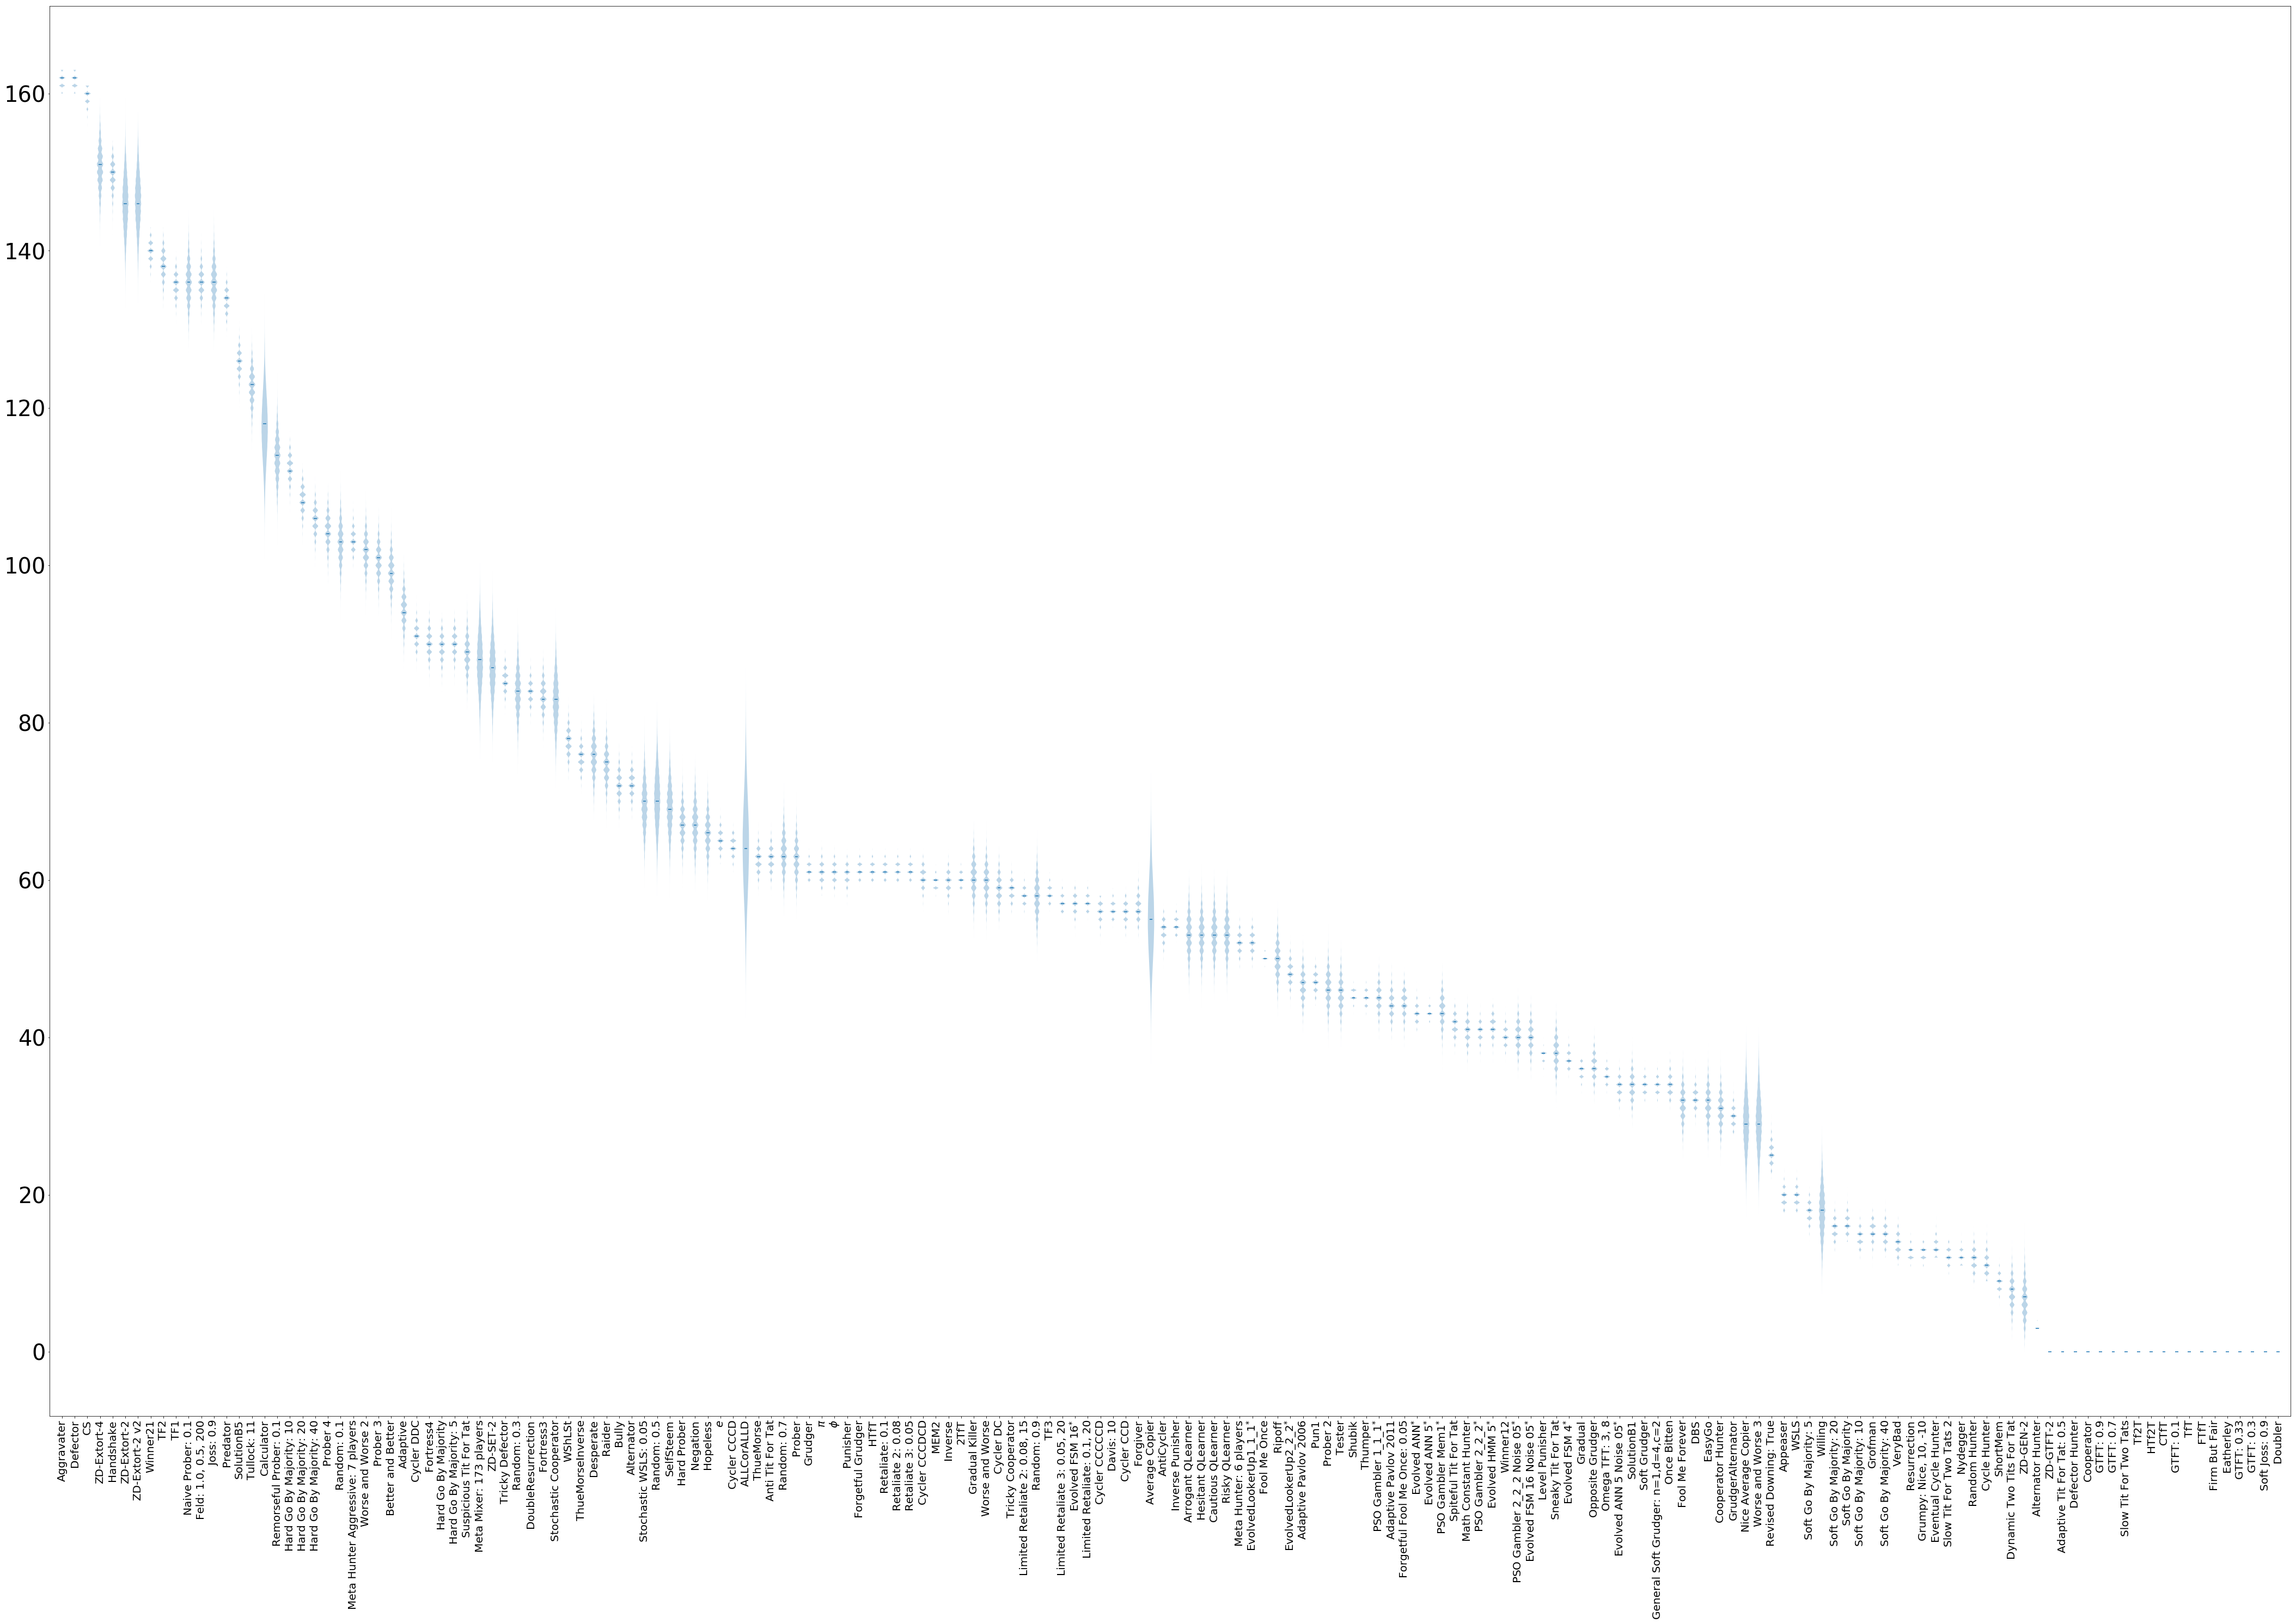

In [22]:
standard_win_summary = standard_win_summary.sort_values("50%", ascending=False)
violon_plot(standard_wins, standard_win_summary, "../assets/standard_wins_boxplots.pdf")

# Study the noisy tournaments


## Scores

In [23]:
noisy_files = glob.glob("./data/*_5_1000*gz")
noisy_scores = read_scores(files=noisy_files)

In [24]:
with open("../assets/noisy_number_of_repetitions.tex", "w") as f:
    f.write(str(len(noisy_scores.index)))

In [25]:
noisy_score_summary = summarise_scores(noisy_scores)
noisy_score_summary.head(15)

mean       std       min        5%  \
DBS                               2.572739  0.024657  2.473857  2.532799   
Evolved ANN 5 Noise 05$^{*}$      2.533822  0.025337  2.417857  2.491686   
Evolved FSM 16 Noise 05$^{*}$     2.514851  0.030740  2.374400  2.464257   
Evolved ANN 5$^{*}$               2.409519  0.030346  2.272714  2.359343   
Evolved FSM 4$^{*}$               2.392745  0.027054  2.286343  2.348343   
Evolved HMM 5$^{*}$               2.391706  0.026091  2.289457  2.348429   
Level Punisher                    2.388432  0.025022  2.280600  2.347114   
Omega TFT: 3, 8                   2.387245  0.026168  2.269514  2.343543   
Spiteful Tit For Tat              2.383148  0.029821  2.259200  2.334427   
Evolved FSM 16$^{*}$              2.374868  0.029451  2.239057  2.325913   
PSO Gambler 2_2_2 Noise 05$^{*}$  2.370808  0.028834  2.249514  2.322857   
Adaptive                          2.369078  0.037997  2.217486  2.306200   
Evolved ANN$^{*}$                 2.365486  0.021886  2.269857  2.329257   
Math Constant Hunter              2.344136  0.022398  2.257286  2.308029   
Gradual                           2.341025  0.021214  2.247943  2.305829   

                                       25%       50%       75%       95%  \
DBS                               2.556029  2.572571  2.589200  2.613914   
Evolved ANN 5 Noise 05$^{*}$      2.516943  2.534229  2.551143  2.574829   
Evolved FSM 16 Noise 05$^{*}$     2.494229  2.514971  2.535714  2.565144   
Evolved ANN 5$^{*}$               2.389229  2.409514  2.430029  2.459114   
Evolved FSM 4$^{*}$               2.374371  2.392686  2.411086  2.437171   
Evolved HMM 5$^{*}$               2.374000  2.391814  2.409371  2.434743   
Level Punisher                    2.371571  2.388657  2.405457  2.429114   
Omega TFT: 3, 8                   2.369629  2.387543  2.405029  2.429829   
Spiteful Tit For Tat              2.363057  2.383171  2.403086  2.432286   
Evolved FSM 16$^{*}$              2.355314  2.375343  2.394800  2.422687   
PSO Gambler 2_2_2 Noise 05$^{*}$  2.351743  2.371057  2.390314  2.417800   
Adaptive                          2.343714  2.369257  2.394943  2.431314   
Evolved ANN$^{*}$                 2.350829  2.365571  2.380143  2.401401   
Math Constant Hunter              2.329029  2.343714  2.358943  2.381800   
Gradual                           2.326771  2.341271  2.355429  2.375571   

                                       max  
DBS                               2.674543  
Evolved ANN 5 Noise 05$^{*}$      2.629000  
Evolved FSM 16 Noise 05$^{*}$     2.642143  
Evolved ANN 5$^{*}$               2.535771  
Evolved FSM 4$^{*}$               2.505114  
Evolved HMM 5$^{*}$               2.493457  
Level Punisher                    2.502886  
Omega TFT: 3, 8                   2.498114  
Spiteful Tit For Tat              2.516771  
Evolved FSM 16$^{*}$              2.507000  
PSO Gambler 2_2_2 Noise 05$^{*}$  2.480200  
Adaptive                          2.523629  
Evolved ANN$^{*}$                 2.482857  
Math Constant Hunter              2.444686  
Gradual                           2.429371

In [26]:
# Write the top 15 players to a tex table
with open("../assets/noisy_top_15_scores_summary.tex", "w") as f:
    f.write(clean_latex(noisy_score_summary.head(15).round(number_of_digits).to_latex()))

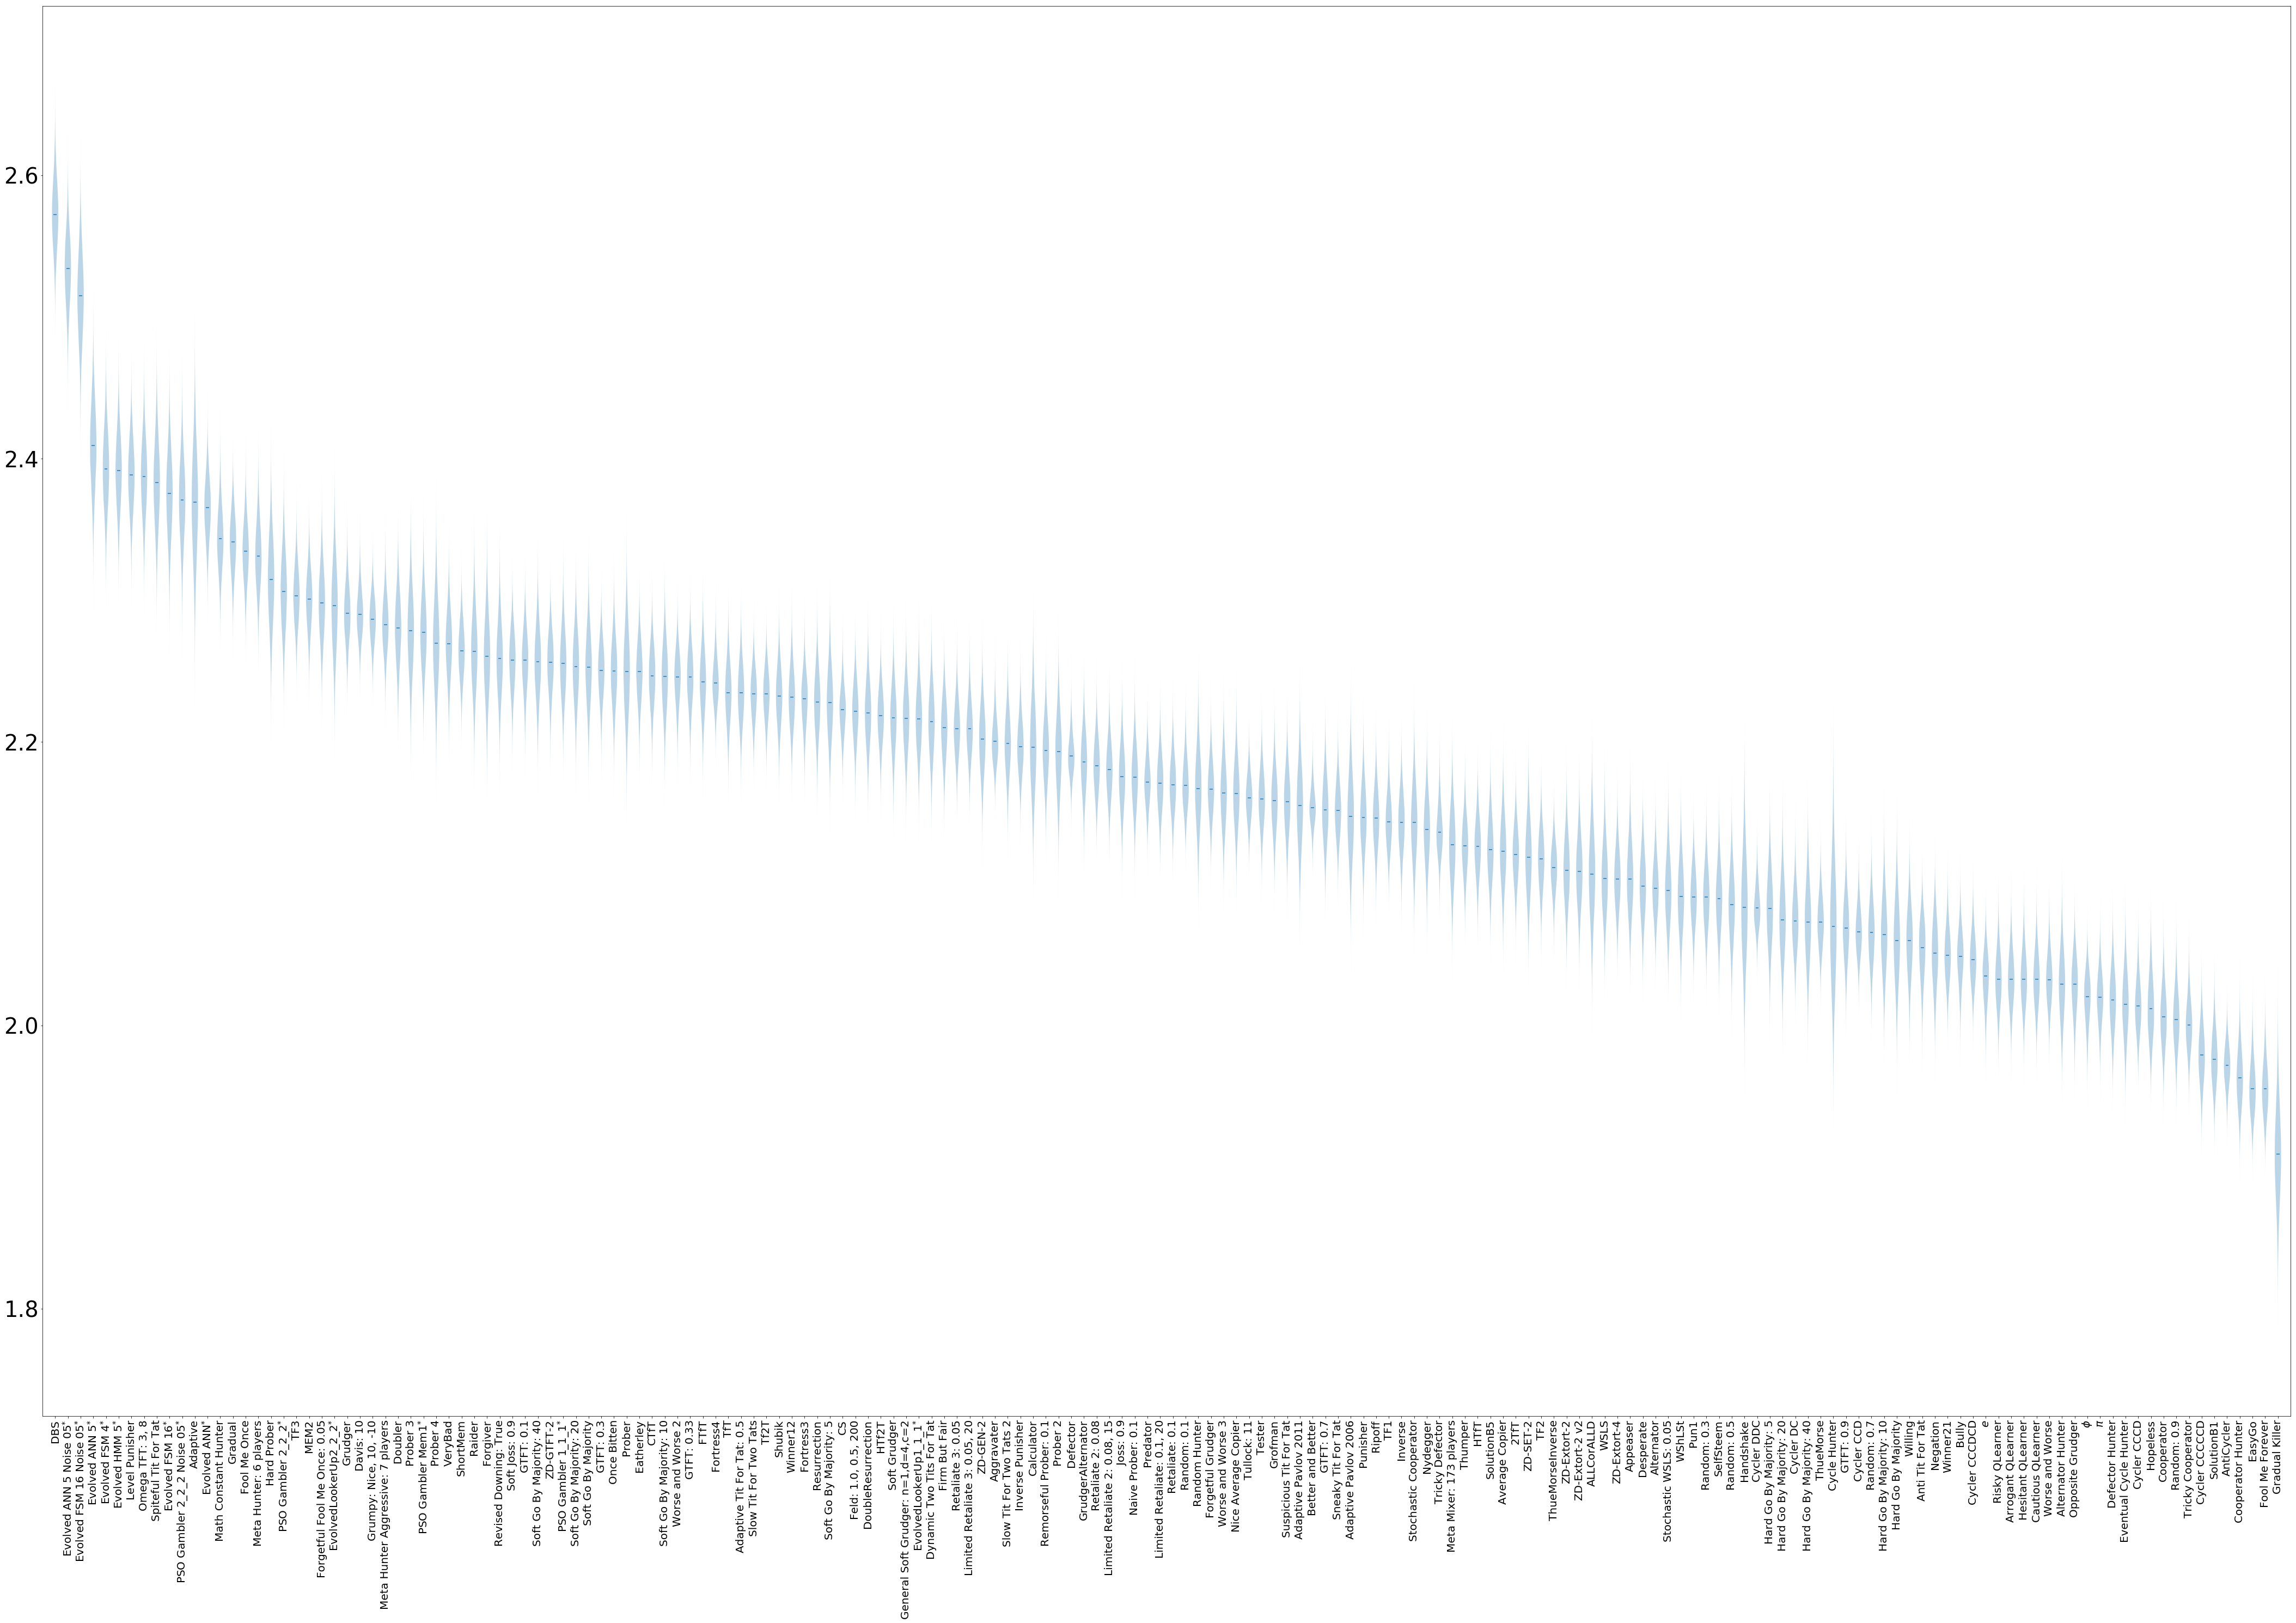

In [27]:
violon_plot(noisy_scores, noisy_score_summary, "../assets/noisy_scores_boxplots.pdf")

## Ranks

In [28]:
noisy_rank_summary = summarise_ranks(noisy_scores)
noisy_rank_summary.head(15)

mean       std  min      5%   25%   50%  \
DBS                                1.20521  0.467588    1   1.000   1.0   1.0   
Evolved ANN 5 Noise 05$^{*}$       2.18370  0.628580    1   1.000   2.0   2.0   
Evolved FSM 16 Noise 05$^{*}$      2.62618  0.618156    1   1.000   2.0   3.0   
Evolved ANN 5$^{*}$                6.37057  2.786088    2   4.000   4.0   5.0   
Evolved FSM 4$^{*}$                7.91869  3.174891    3   4.000   5.0   7.0   
Evolved HMM 5$^{*}$                7.99584  3.109649    3   4.000   6.0   7.0   
Level Punisher                     8.33719  3.082581    3   4.000   6.0   8.0   
Omega TFT: 3, 8                    8.50954  3.248718    3   4.000   6.0   8.0   
Spiteful Tit For Tat               9.15901  3.772463    3   4.000   6.0   9.0   
Evolved FSM 16$^{*}$              10.21808  4.098758    3   4.975   7.0  10.0   
PSO Gambler 2_2_2 Noise 05$^{*}$  10.75989  4.102154    3   5.000   8.0  10.0   
Evolved ANN$^{*}$                 11.34606  3.252000    3   6.000   9.0  11.0   
Adaptive                          11.41958  5.738897    3   4.000   7.0  11.0   
Math Constant Hunter              14.66761  3.788323    3   9.000  12.0  15.0   
Gradual                           15.16302  3.671918    4  10.000  13.0  15.0   

                                   75%   95%  max  
DBS                                1.0   2.0    3  
Evolved ANN 5 Noise 05$^{*}$       3.0   3.0    5  
Evolved FSM 16 Noise 05$^{*}$      3.0   3.0    9  
Evolved ANN 5$^{*}$                8.0  12.0   31  
Evolved FSM 4$^{*}$               10.0  14.0   33  
Evolved HMM 5$^{*}$               10.0  14.0   26  
Level Punisher                    10.0  14.0   26  
Omega TFT: 3, 8                   11.0  14.0   32  
Spiteful Tit For Tat              12.0  16.0   40  
Evolved FSM 16$^{*}$              13.0  17.0   56  
PSO Gambler 2_2_2 Noise 05$^{*}$  13.0  18.0   47  
Evolved ANN$^{*}$                 13.0  17.0   32  
Adaptive                          14.0  21.0   63  
Math Constant Hunter              17.0  21.0   43  
Gradual                           17.0  21.0   49

In [29]:
# Write the top 15 players to a tex table
with open("../assets/noisy_top_15_ranks_summary.tex", "w") as f:
    f.write(clean_latex(noisy_rank_summary.head(15).round(number_of_digits).to_latex()))

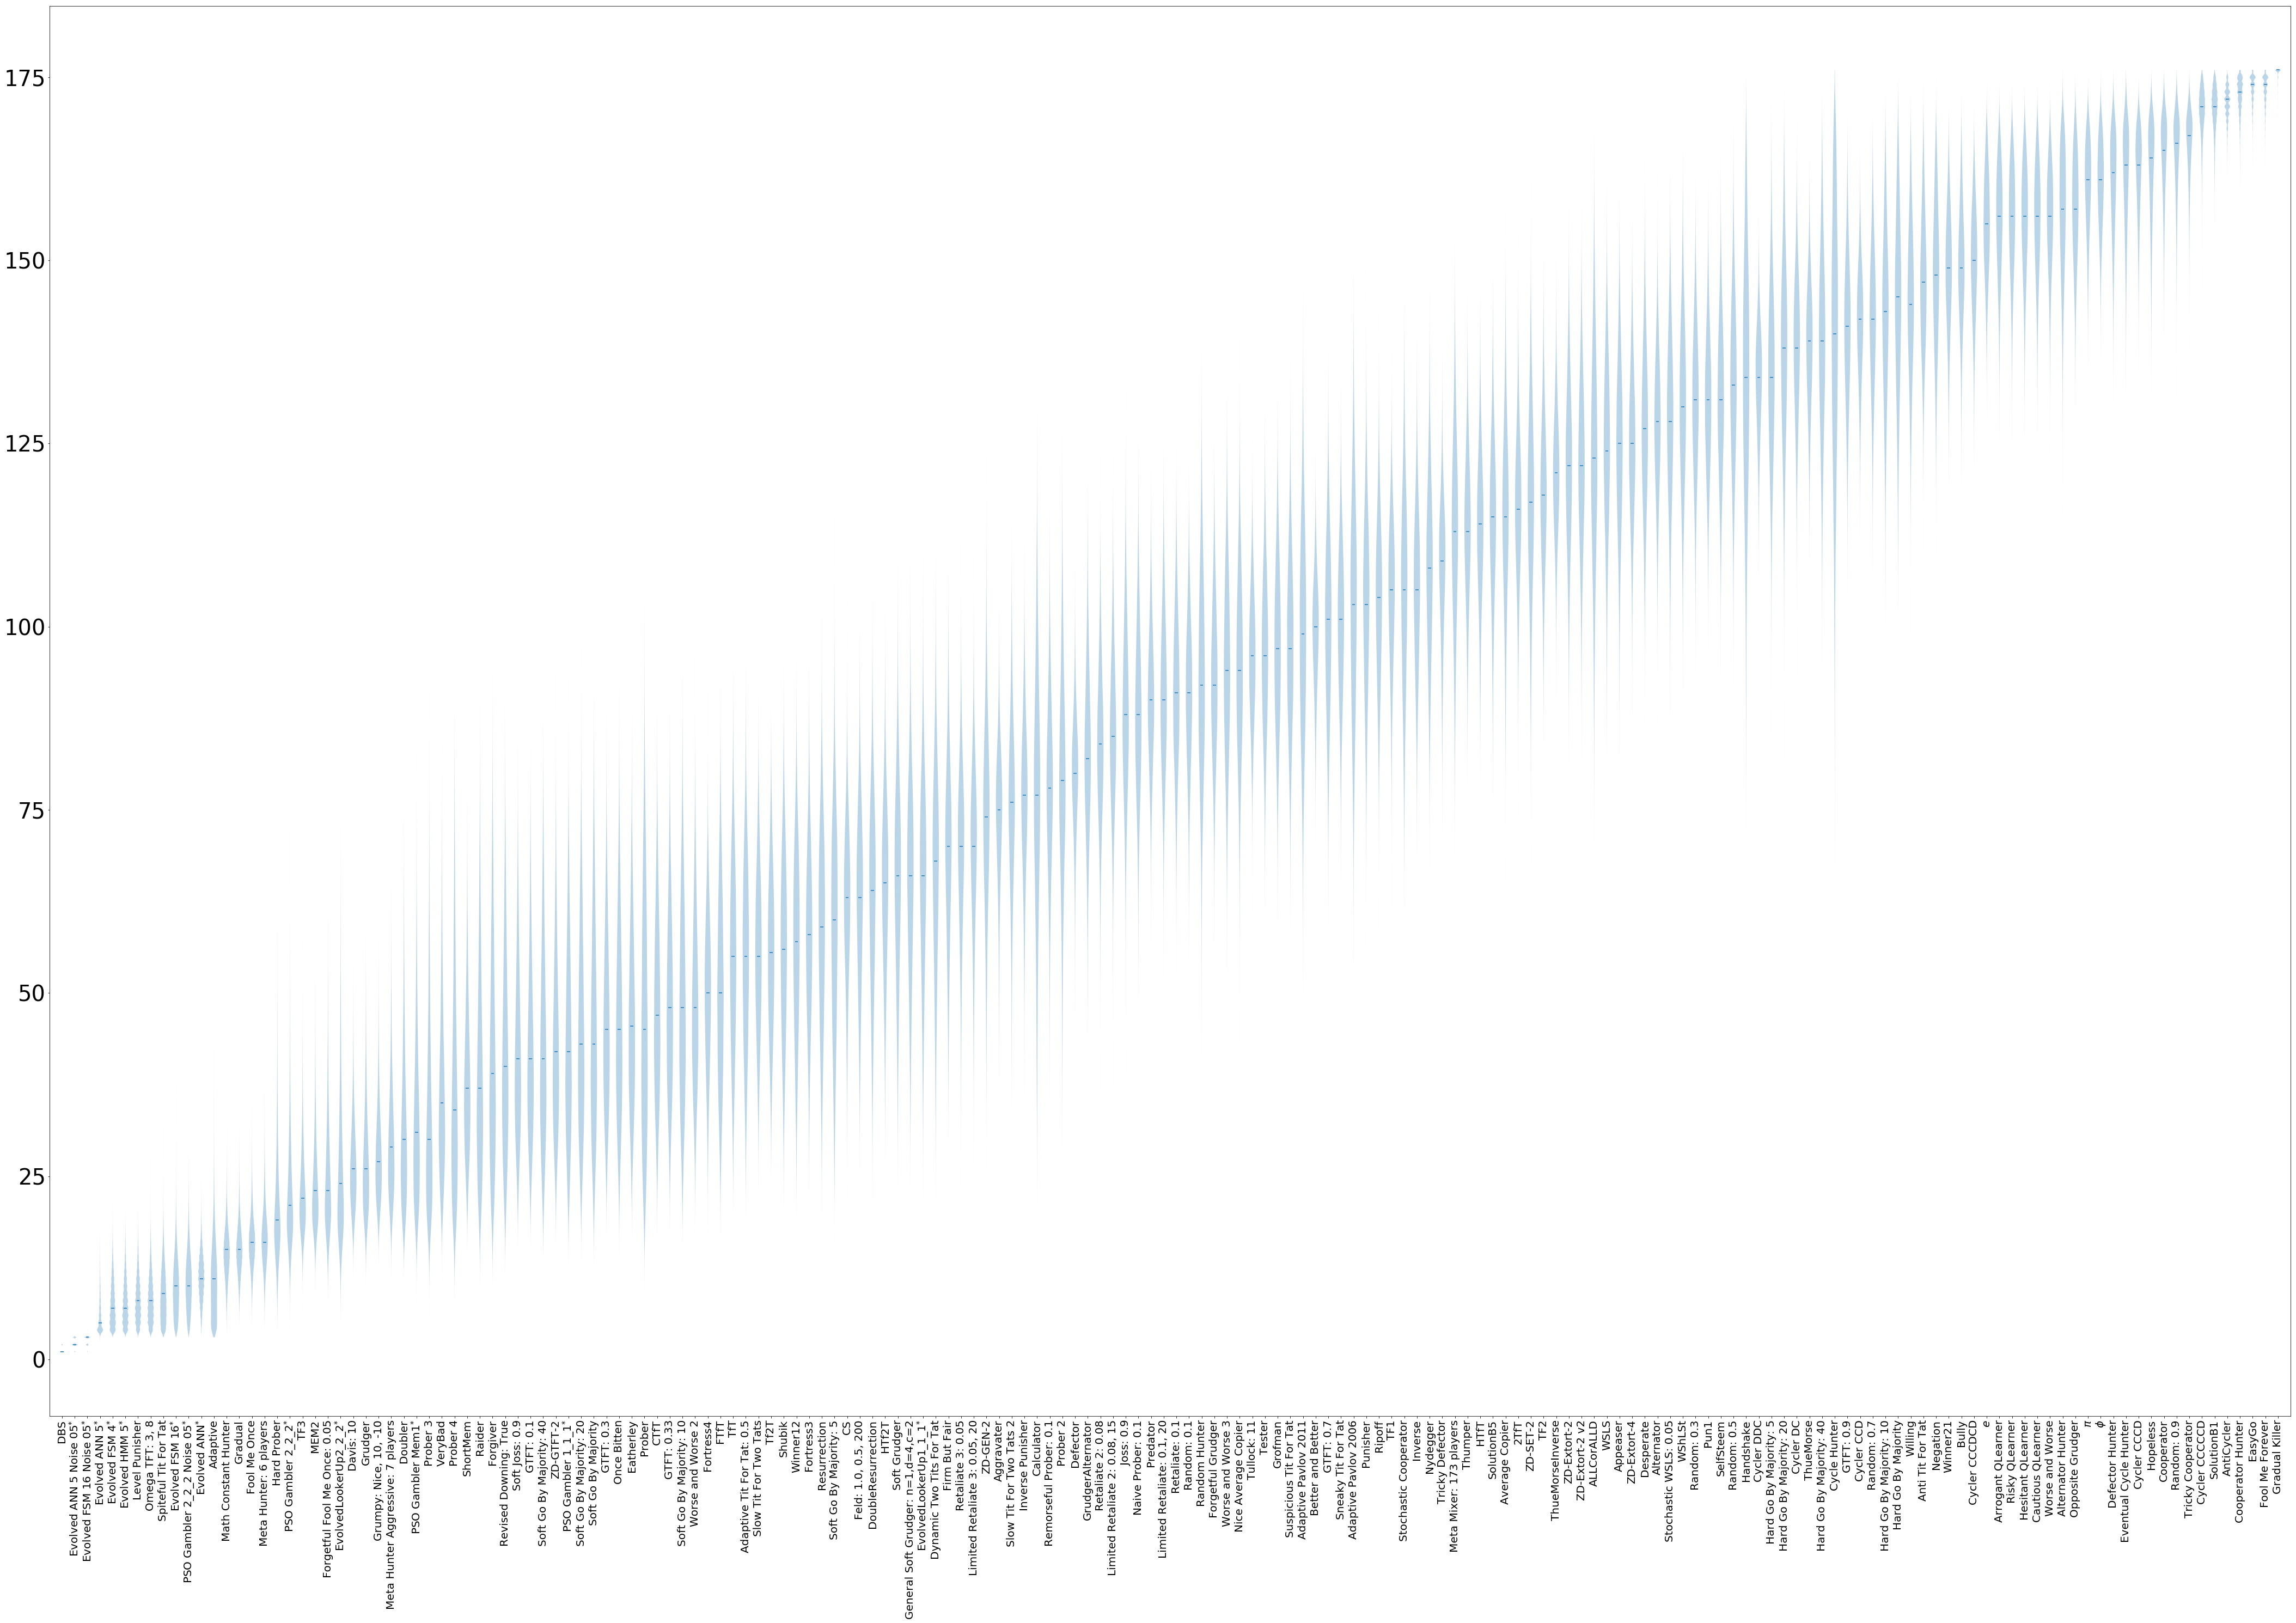

In [30]:
violon_plot(noisy_scores.rank(axis=1, ascending=False), noisy_rank_summary, "../assets/noisy_ranks_boxplots.pdf")

## Payoff matrix

In [31]:
noisy_payoff_matrix = read_payoff_matrix(files=noisy_files)
assert noisy_payoff_matrix.shape == (176, 176)

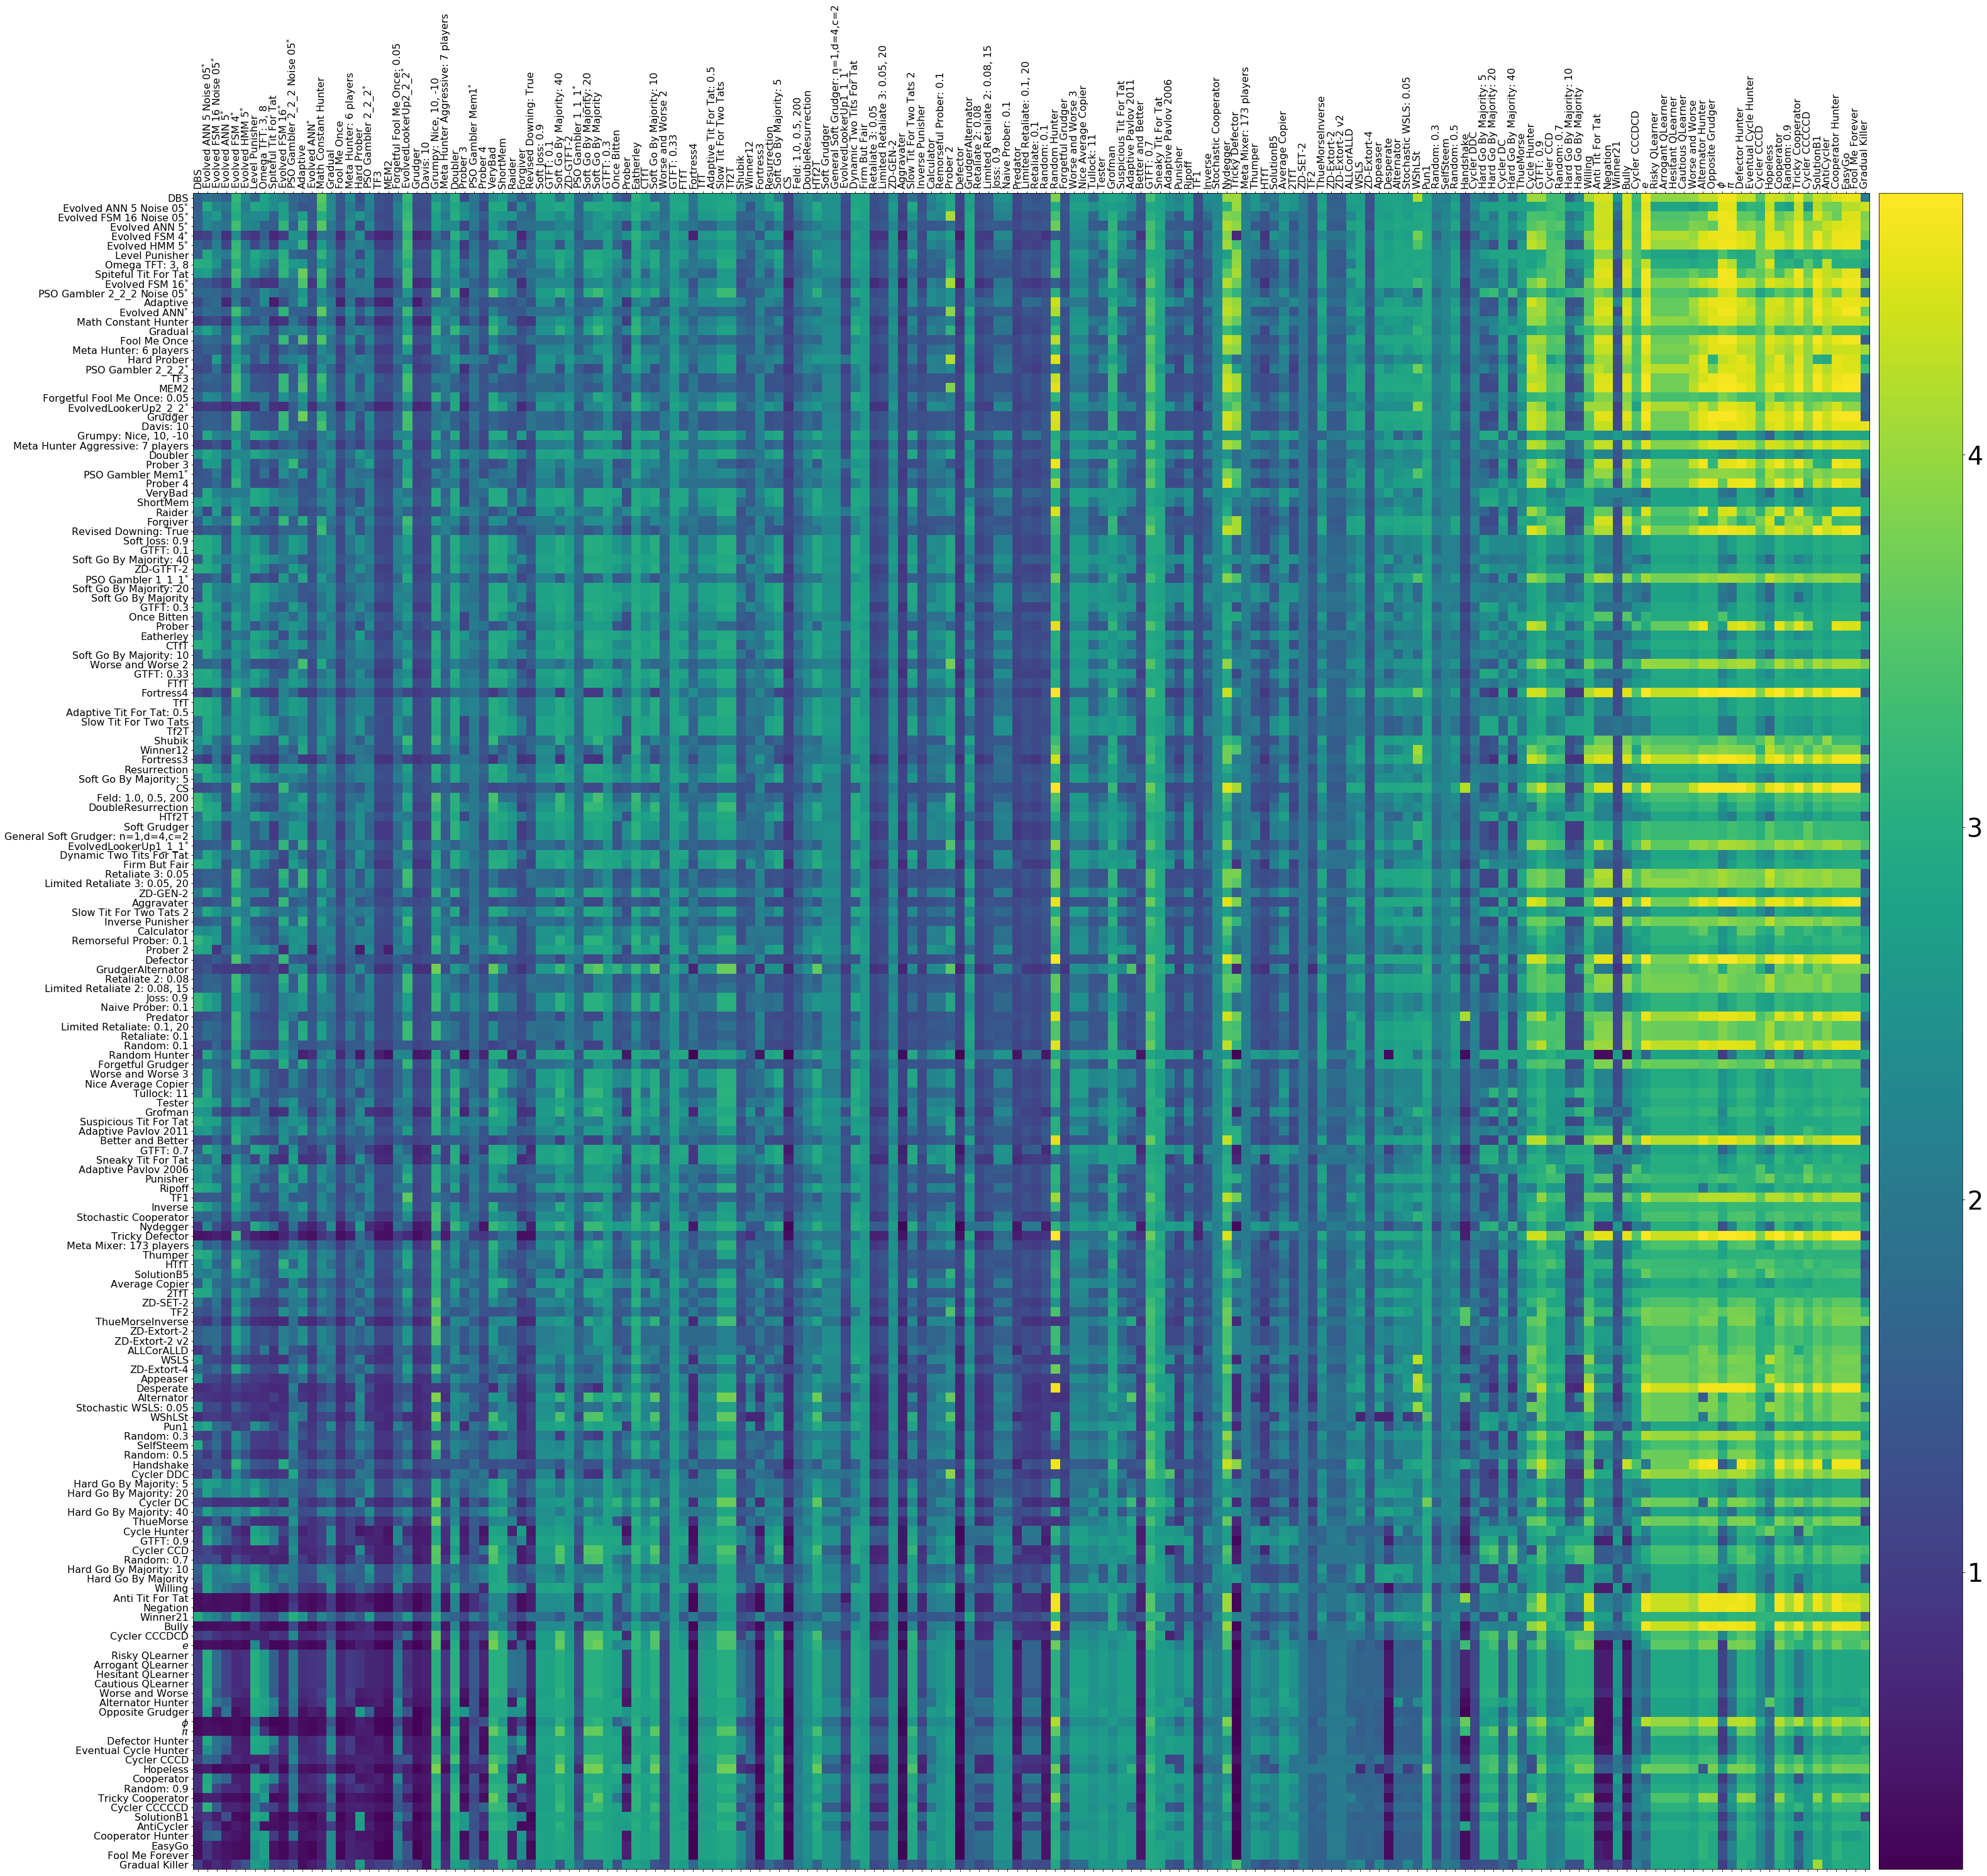

In [32]:
noisy_ranked_player_names = list(noisy_score_summary.index)
noisy_ranked_indices = [player_names.index(name) for name in noisy_ranked_player_names]
noisy_ranked_payoff_matrix = noisy_payoff_matrix[noisy_ranked_indices][:, noisy_ranked_indices]

for i, _ in enumerate(player_names):  # Check that ordering has been done correctly
    assert noisy_payoff_matrix[i, i] == noisy_ranked_payoff_matrix[noisy_ranked_indices.index(i), 
                                                                   noisy_ranked_indices.index(i)]

payoff_heatmap(noisy_ranked_payoff_matrix, noisy_ranked_player_names, "../assets/noisy_scores_heatmap.pdf")

## Wins

In [33]:
noisy_wins = read_wins(files=noisy_files)

In [34]:
noisy_win_summary = summarise_wins(noisy_wins, noisy_score_summary)
noisy_win_summary.head(15)

mean       std  min     5%    25%  \
DBS                               102.54520  3.671303   87   97.0  100.0   
Evolved ANN 5 Noise 05$^{*}$       75.02584  4.225547   57   68.0   72.0   
Evolved FSM 16 Noise 05$^{*}$      88.69902  3.863523   74   82.0   86.0   
Evolved ANN 5$^{*}$               137.87750  4.350024  118  131.0  135.0   
Evolved FSM 4$^{*}$                74.24962  2.694412   64   70.0   72.0   
Evolved HMM 5$^{*}$                88.18906  2.773783   77   84.0   86.0   
Level Punisher                     94.26298  4.788616   75   86.0   91.0   
Omega TFT: 3, 8                   131.65468  4.301591  112  125.0  129.0   
Spiteful Tit For Tat              155.02982  3.326150  133  150.0  153.0   
Evolved FSM 16$^{*}$              103.28790  3.631451   89   97.0  101.0   
PSO Gambler 2_2_2 Noise 05$^{*}$   90.51490  4.011750   75   84.0   88.0   
Adaptive                          101.89772  4.898953   83   94.0   99.0   
Evolved ANN$^{*}$                 138.51416  3.400769  125  133.0  136.0   
Math Constant Hunter               93.00992  3.253791   79   88.0   91.0   
Gradual                           101.89902  2.869618   91   97.0  100.0   

                                    50%    75%    95%  max  
DBS                               103.0  105.0  109.0  118  
Evolved ANN 5 Noise 05$^{*}$       75.0   78.0   82.0   93  
Evolved FSM 16 Noise 05$^{*}$      89.0   91.0   95.0  104  
Evolved ANN 5$^{*}$               138.0  141.0  145.0  156  
Evolved FSM 4$^{*}$                74.0   76.0   79.0   85  
Evolved HMM 5$^{*}$                88.0   90.0   93.0   99  
Level Punisher                     94.0   97.0  102.0  116  
Omega TFT: 3, 8                   132.0  135.0  139.0  150  
Spiteful Tit For Tat              155.0  157.0  160.0  167  
Evolved FSM 16$^{*}$              103.0  106.0  109.0  118  
PSO Gambler 2_2_2 Noise 05$^{*}$   90.0   93.0   97.0  109  
Adaptive                          102.0  105.0  110.0  124  
Evolved ANN$^{*}$                 139.0  141.0  144.0  153  
Math Constant Hunter               93.0   95.0   98.0  107  
Gradual                           102.0  104.0  107.0  114

In [35]:
noisy_win_summary.sort_values("50%", ascending=False).head(15)

mean       std  min     5%    25%    50%    75%  \
Aggravater            156.65372  3.327629  141  151.0  154.0  157.0  159.0   
CS                    156.87464  3.264539  144  151.0  155.0  157.0  159.0   
Defector              157.32370  3.261946  144  152.0  155.0  157.0  160.0   
Grudger               155.59034  3.302698  143  150.0  153.0  156.0  158.0   
Retaliate 3: 0.05     155.38206  3.305902  141  150.0  153.0  155.0  158.0   
Retaliate 2: 0.08     155.36488  3.319645  140  150.0  153.0  155.0  158.0   
MEM2                  155.05232  3.348798  140  149.0  153.0  155.0  157.0   
HTfT                  155.29796  3.343532  141  150.0  153.0  155.0  158.0   
Retaliate: 0.1        155.37022  3.313719  139  150.0  153.0  155.0  158.0   
Spiteful Tit For Tat  155.02982  3.326150  133  150.0  153.0  155.0  157.0   
Punisher              153.28052  3.375005  140  148.0  151.0  153.0  156.0   
2TfT                  152.82304  3.428580  138  147.0  151.0  153.0  155.0   
TF3                   153.03146  3.327115  138  148.0  151.0  153.0  155.0   
Fool Me Once          152.81724  3.344473  138  147.0  151.0  153.0  155.0   
Predator              151.40580  3.402646  138  146.0  149.0  151.0  154.0   

                        95%  max  
Aggravater            162.0  170  
CS                    162.0  169  
Defector              163.0  170  
Grudger               161.0  168  
Retaliate 3: 0.05     161.0  169  
Retaliate 2: 0.08     161.0  169  
MEM2                  160.0  169  
HTfT                  161.0  168  
Retaliate: 0.1        161.0  168  
Spiteful Tit For Tat  160.0  167  
Punisher              159.0  167  
2TfT                  158.0  165  
TF3                   158.0  166  
Fool Me Once          158.0  166  
Predator              157.0  165

In [36]:
# Write the top 15 players to a tex table
with open("../assets/noisy_top_15_wins_summary.tex", "w") as f:
    f.write(clean_latex(noisy_win_summary.head(15).round(number_of_digits).to_latex()))

In [37]:
# Write the top 15 winning players to a tex table
with open("../assets/noisy_top_15_winners_wins_summary.tex", "w") as f:
    f.write(clean_latex(noisy_win_summary.sort_values("50%", ascending=False).head(15).round(number_of_digits).to_latex()))

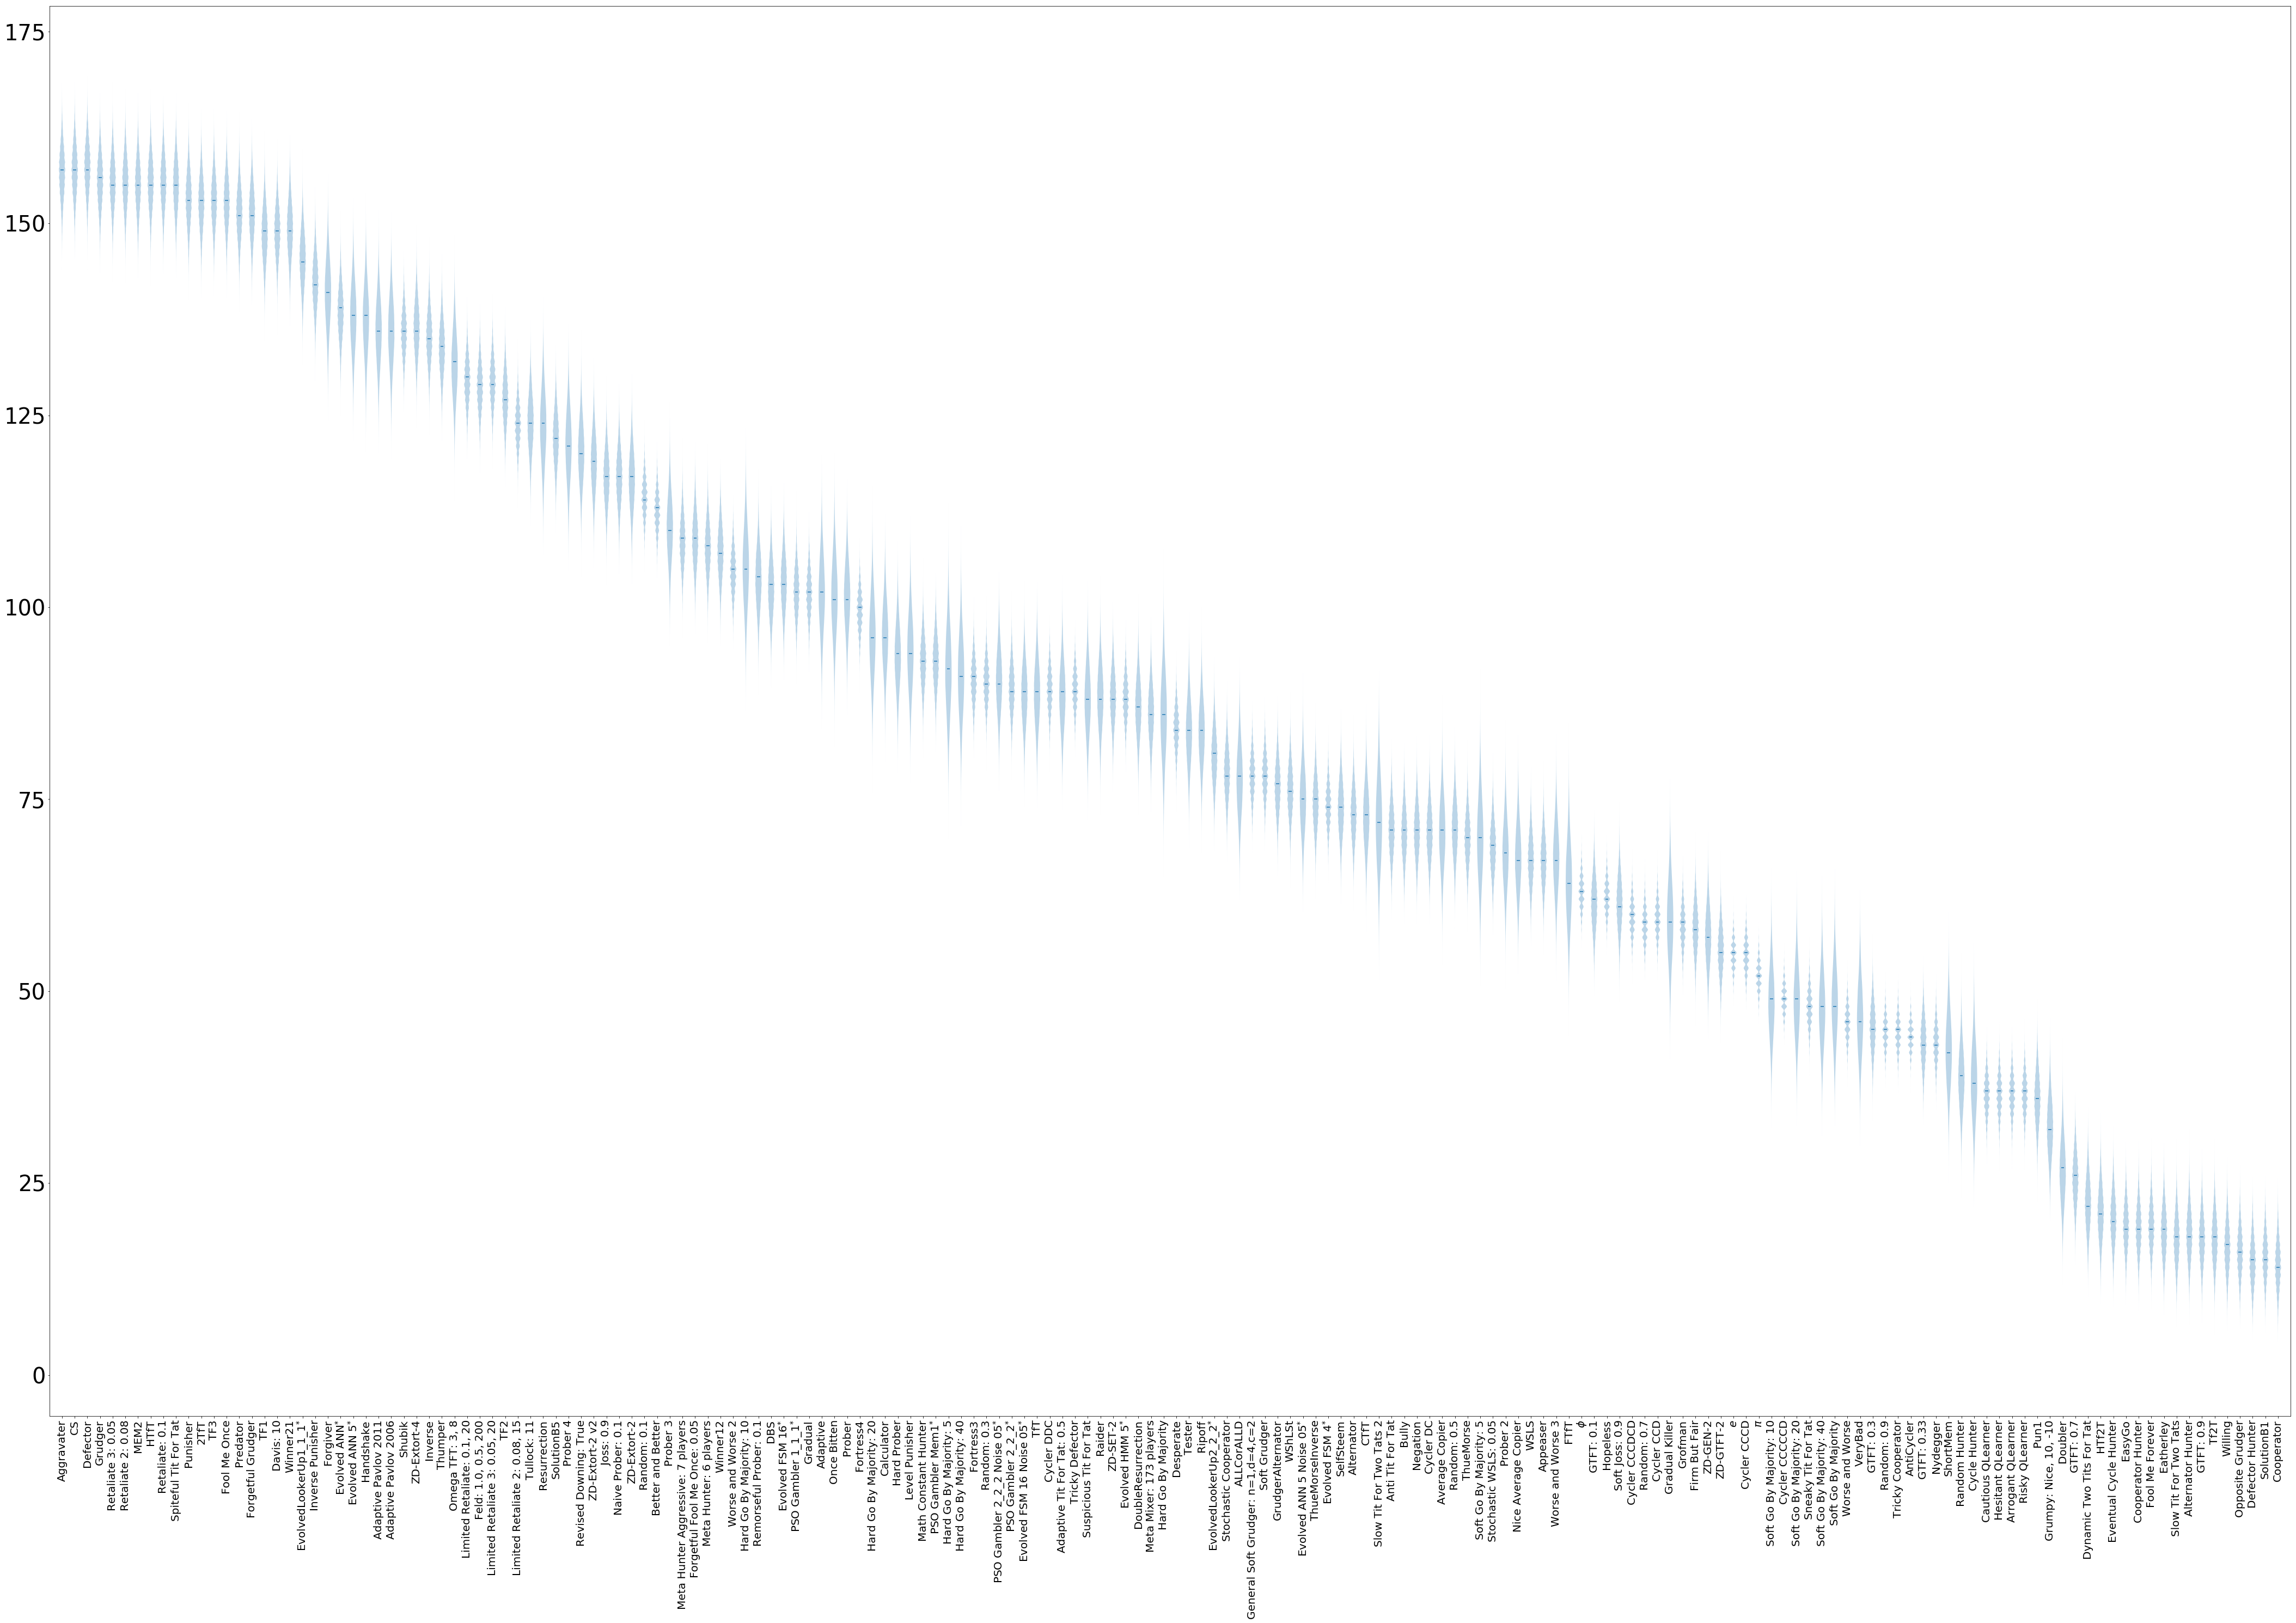

In [38]:
noisy_win_summary = noisy_win_summary.sort_values("50%", ascending=False)
violon_plot(noisy_wins, noisy_win_summary, "../assets/noisy_wins_boxplots.pdf")

# Draw cooperation heatmaps

In [39]:
def cooperation_heatmap(filename, player_names=standard_ranked_player_names, order=standard_ranked_indices):
    
    matrix = np.array(pd.read_csv(filename, header=None))
    matrix = matrix[order]
    assert matrix.shape == (len(player_names), 200)
    
    fig, ax = plt.subplots()
    width = number_of_players / 4
    height = width
    spacing = 4 
    fig.set_size_inches(width, height) 

    mat = ax.matshow(matrix)

    ax.set_yticks(range(number_of_players))
    ax.set_yticklabels(player_names)
    ax.set_xlabel("Rounds", fontsize=40)
    ax.tick_params(axis='both', which='both', labelsize=16) 

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    cax.tick_params(labelsize=40) 
    cbar = fig.colorbar(mat, cax=cax)
    fig.tight_layout()
    
    base = os.path.basename(filename)
    plot_file_name, _ = os.path.splitext(base)
    plot_file_name = plot_file_name.replace(" ", "_")
    plot_file_name = plot_file_name.replace(".", "-")
    plot_file_name = plot_file_name.replace(",", "")
    plot_file_name = plot_file_name.replace(":", "")
    plot_file_name = plot_file_name.replace("__", "_")
    fig.savefig("../assets/{}.pdf".format(plot_file_name))

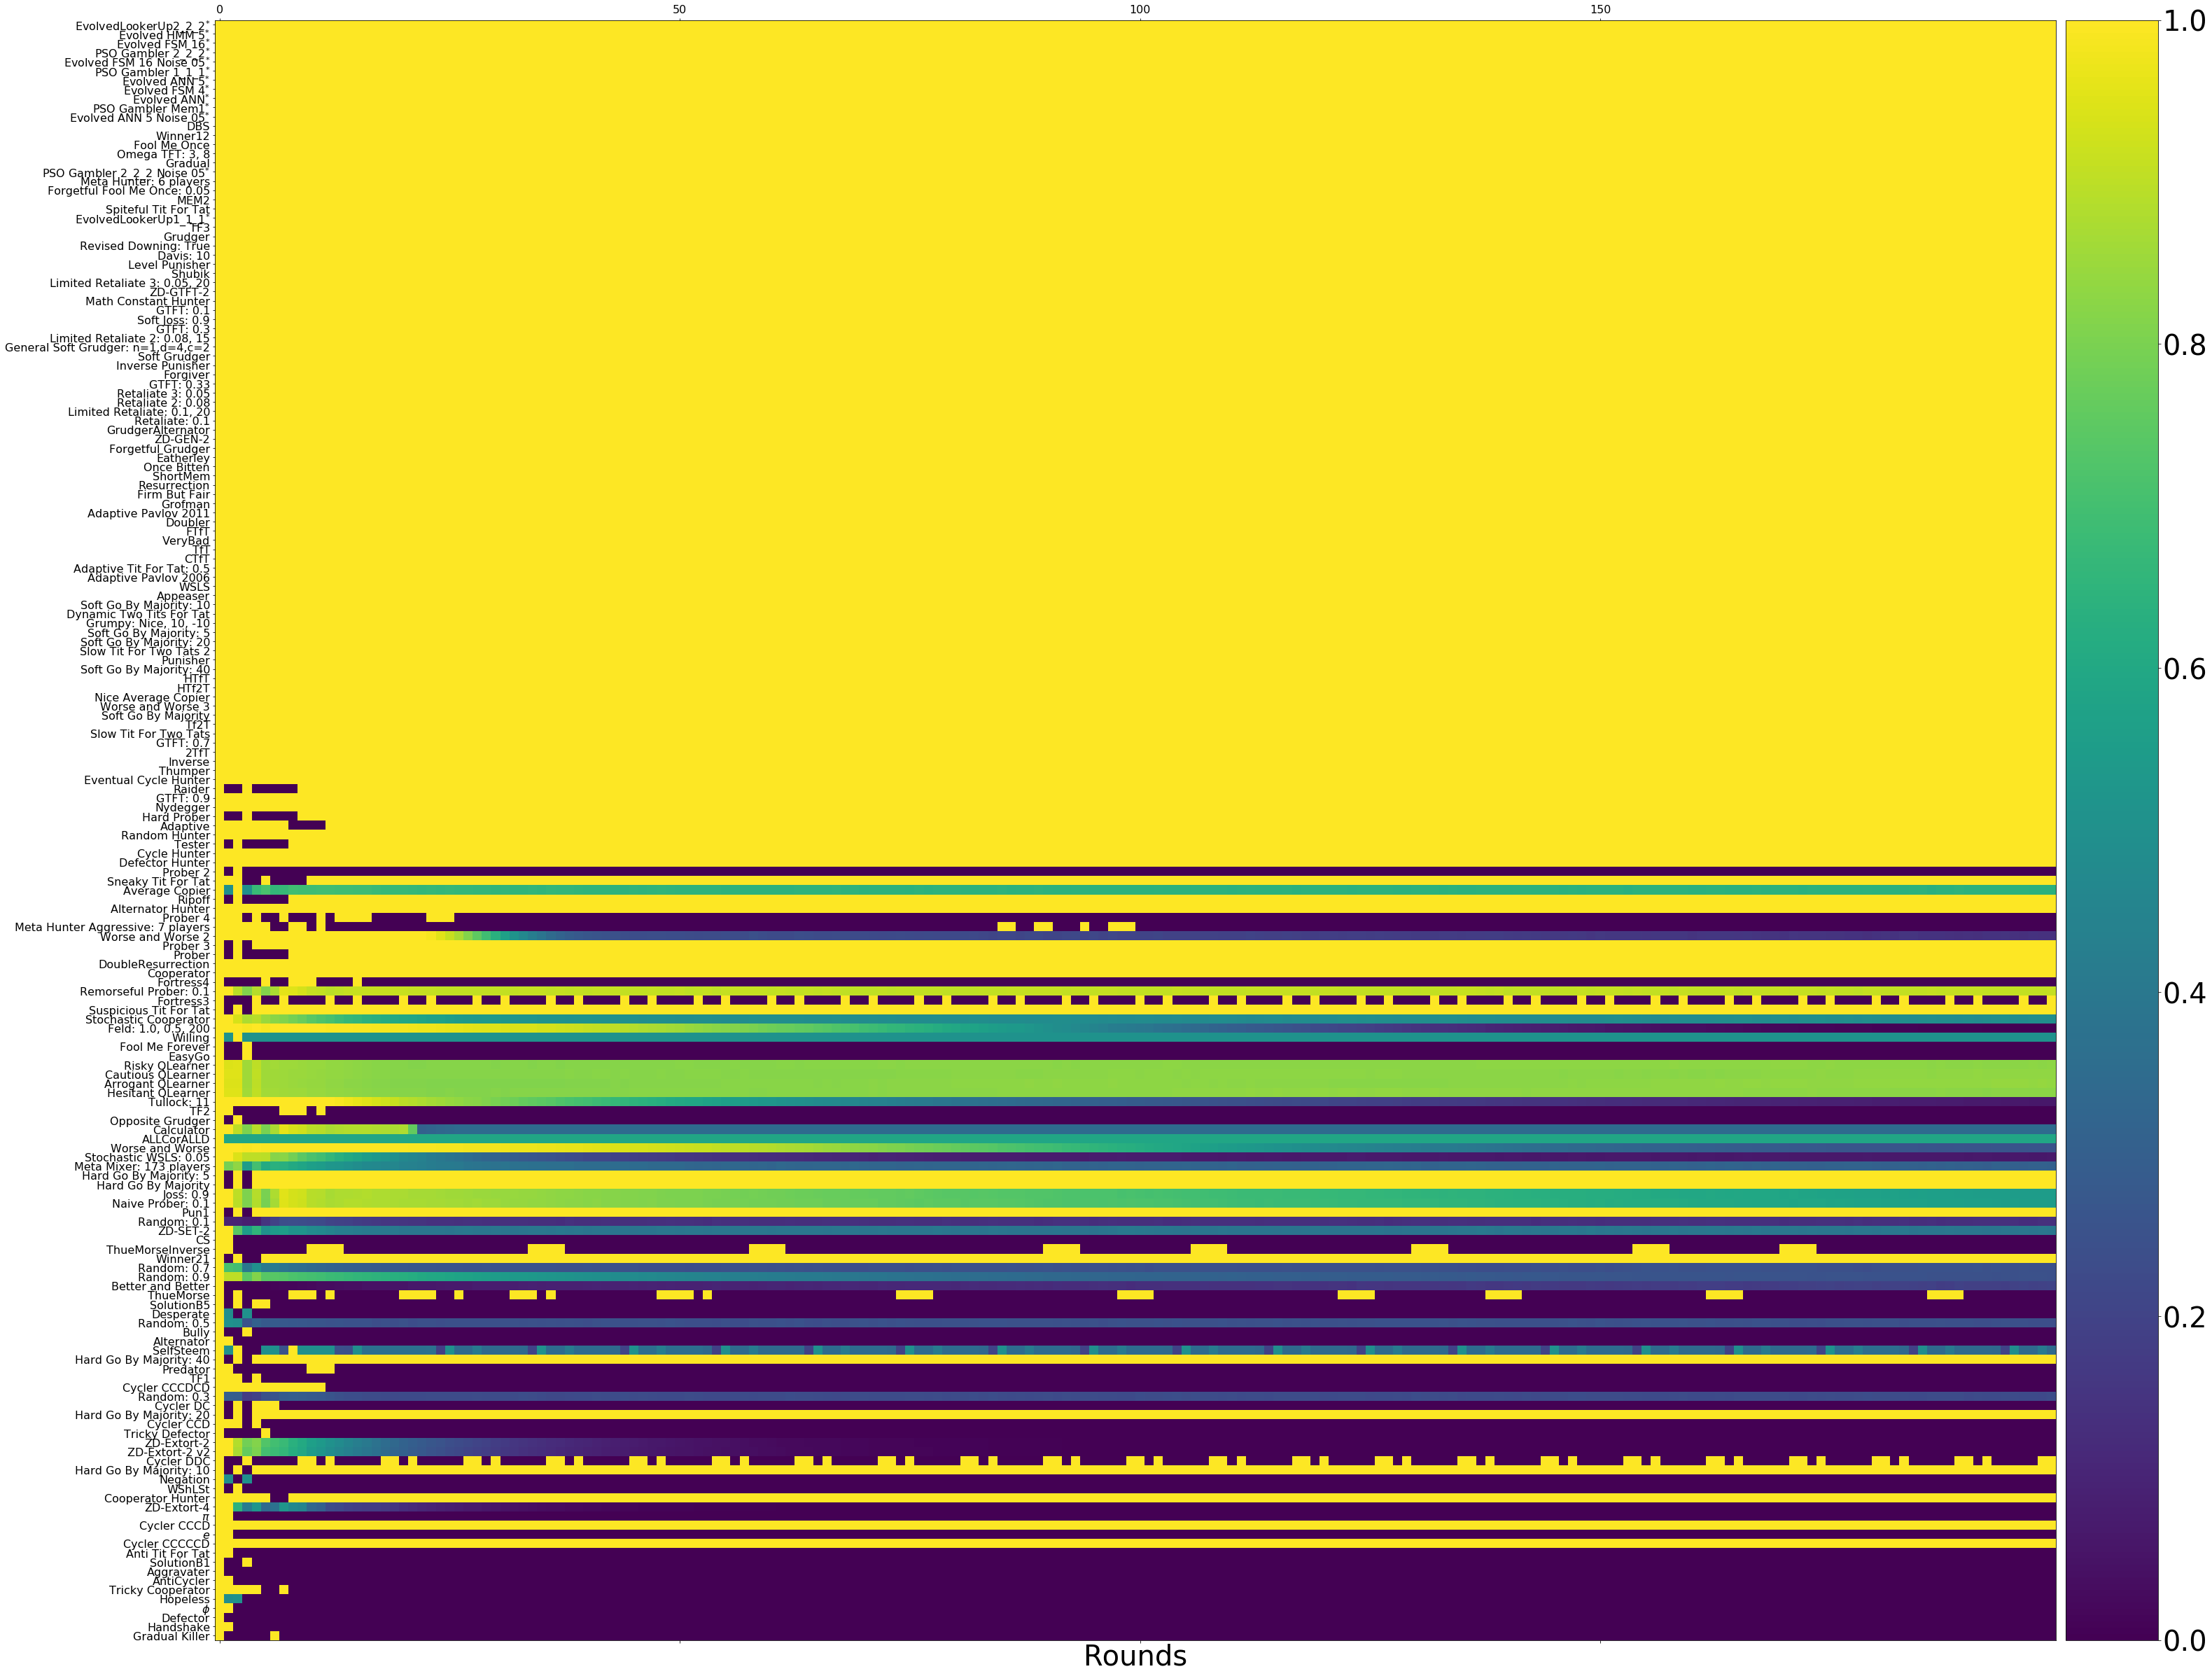

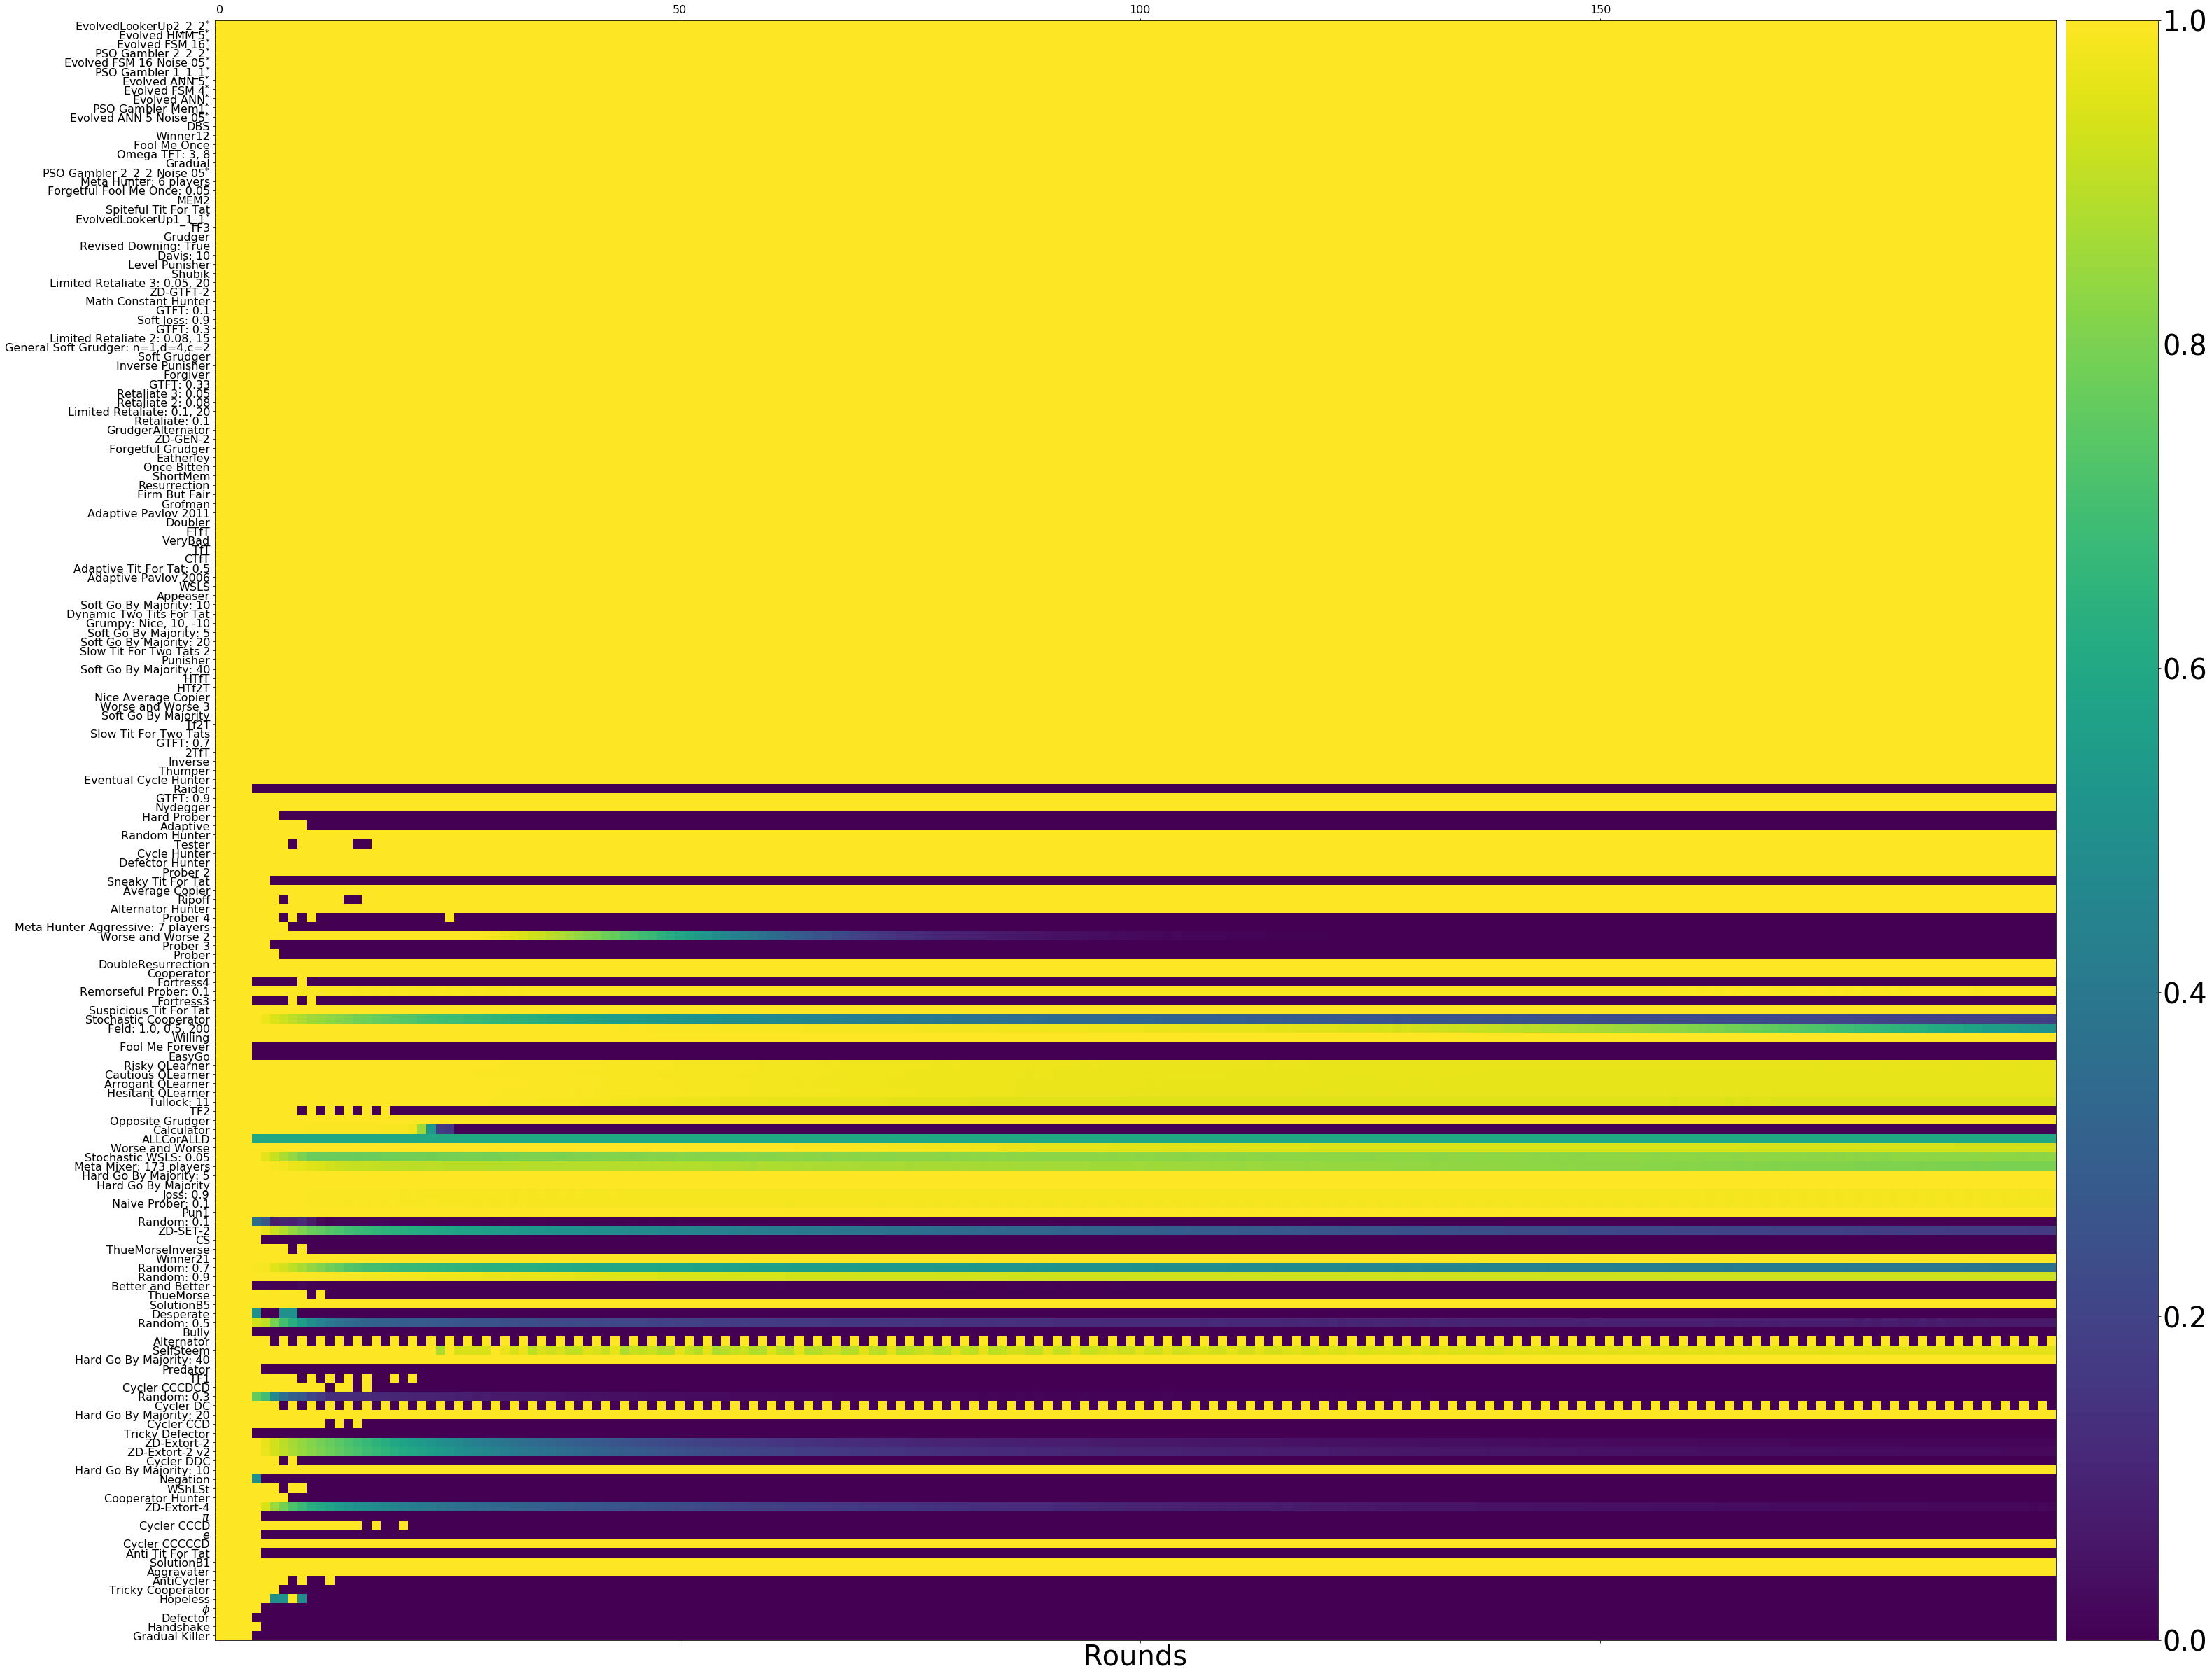

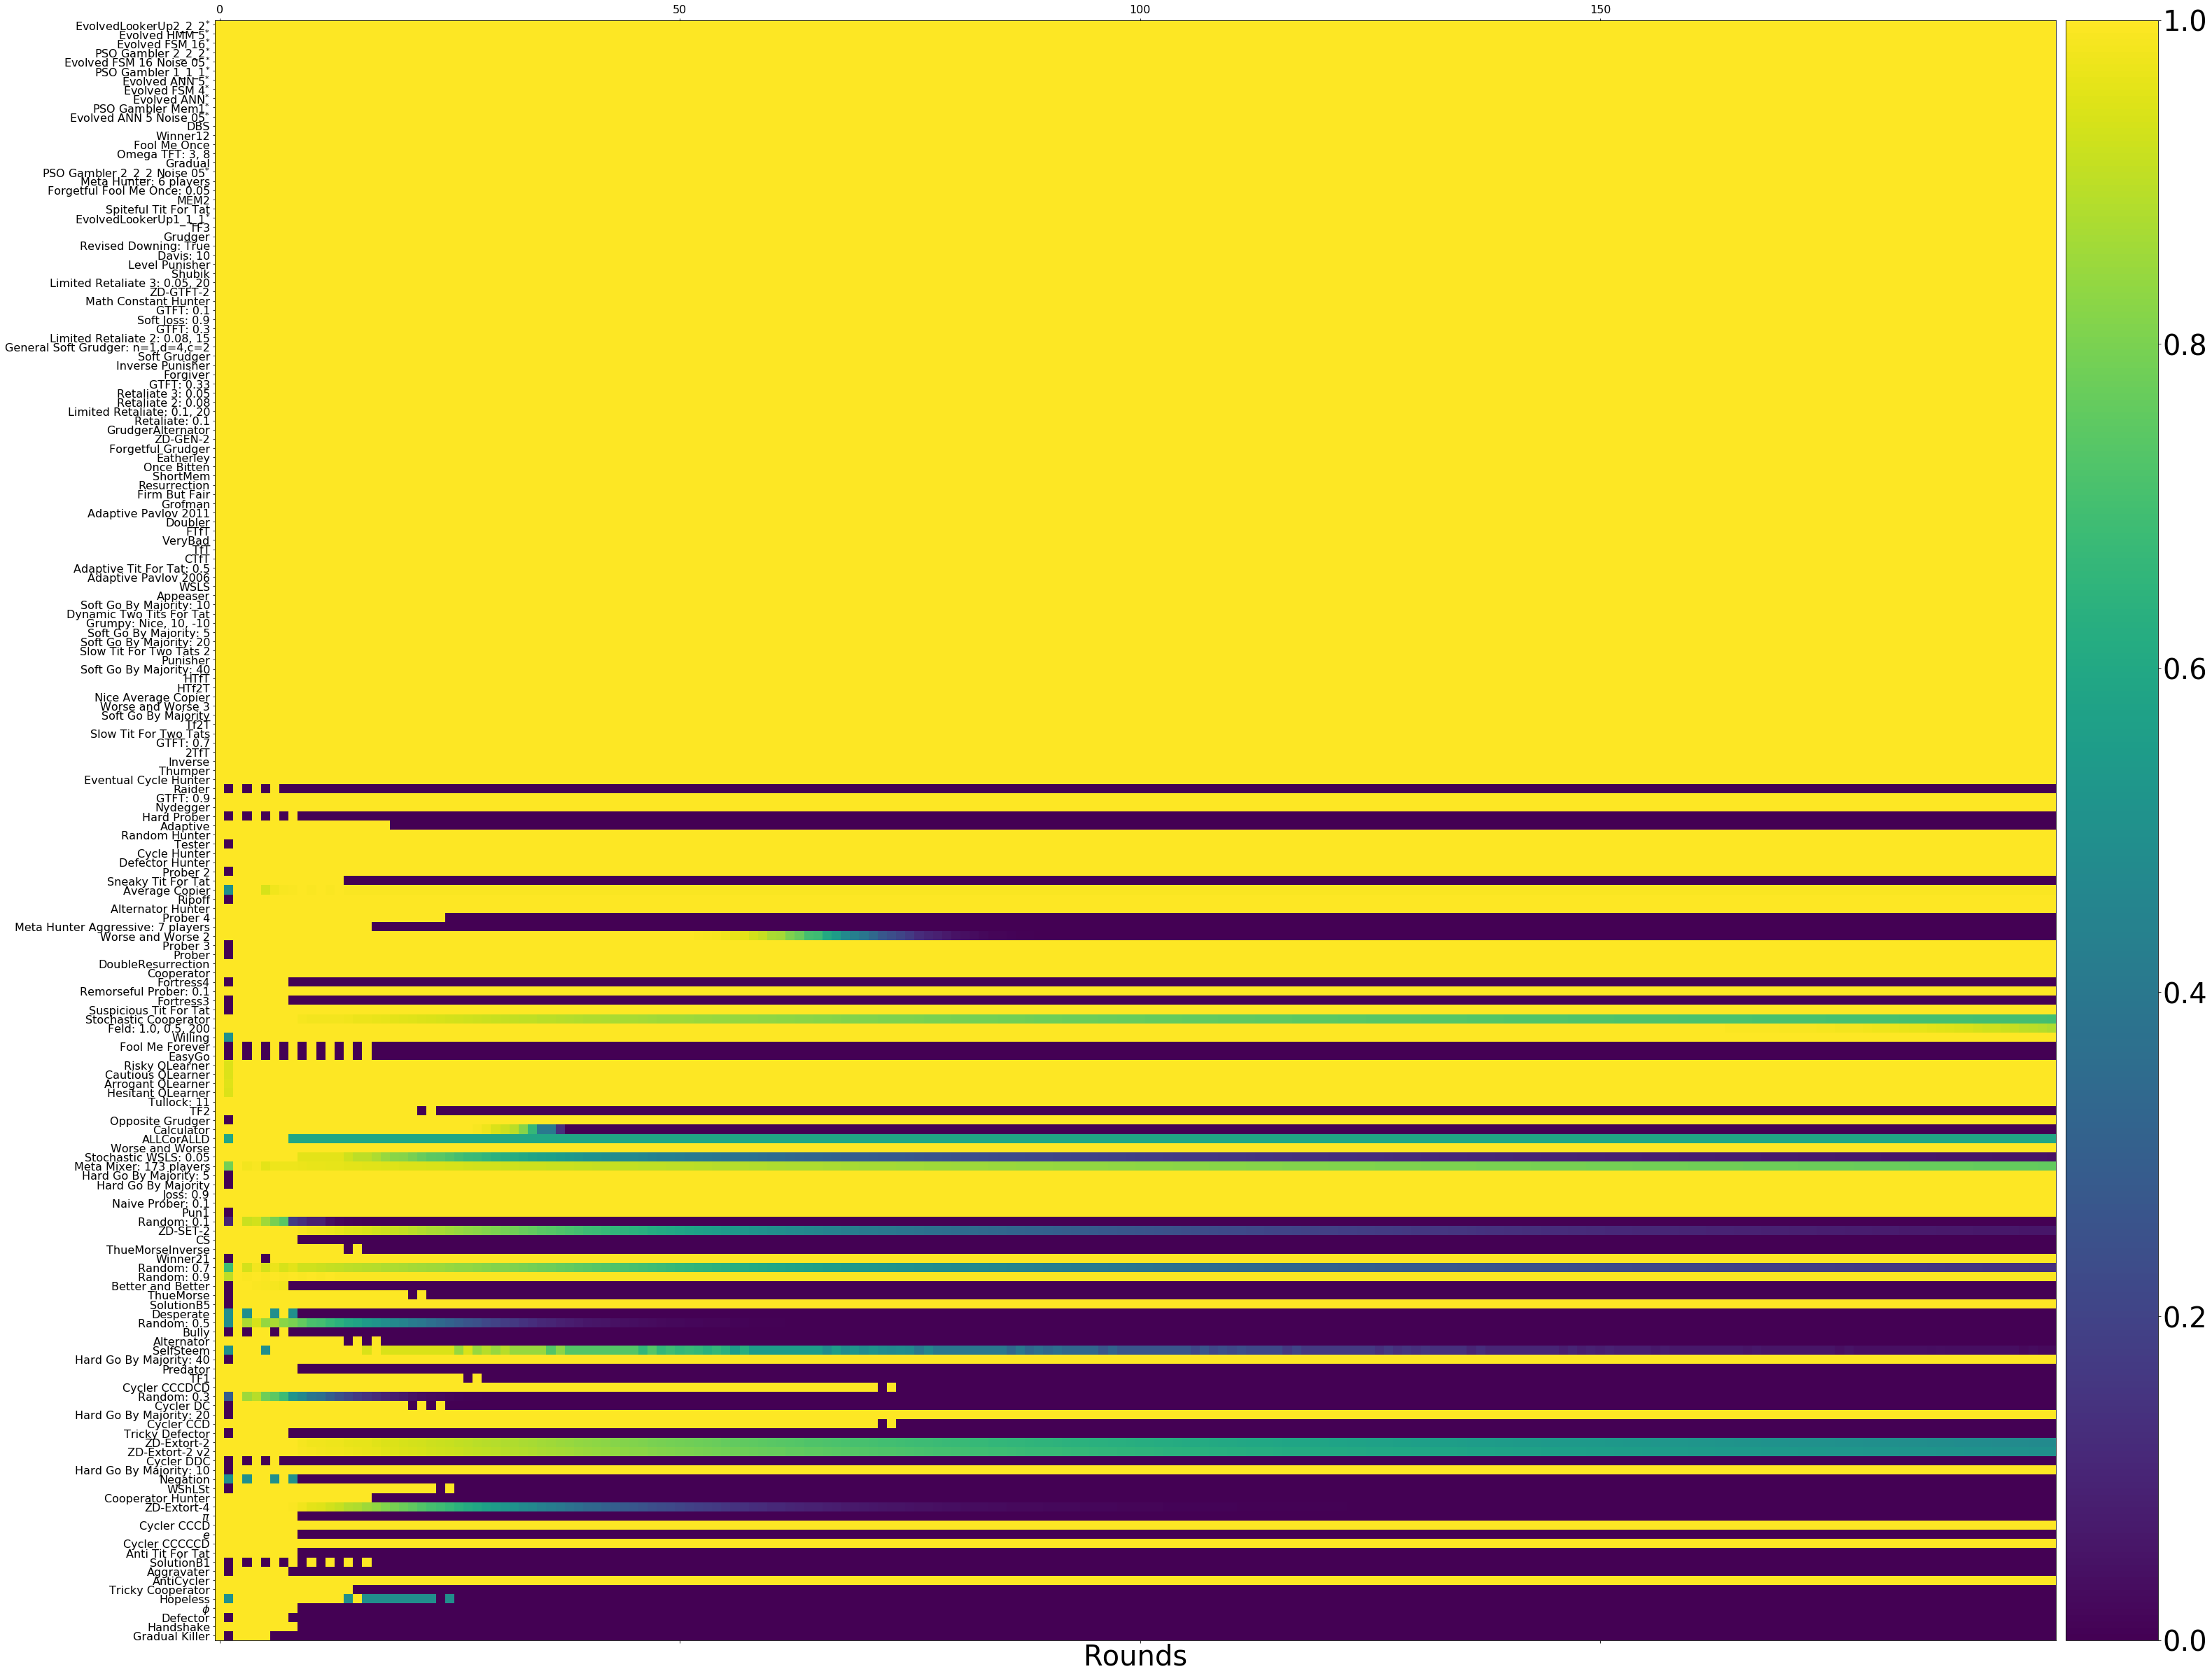

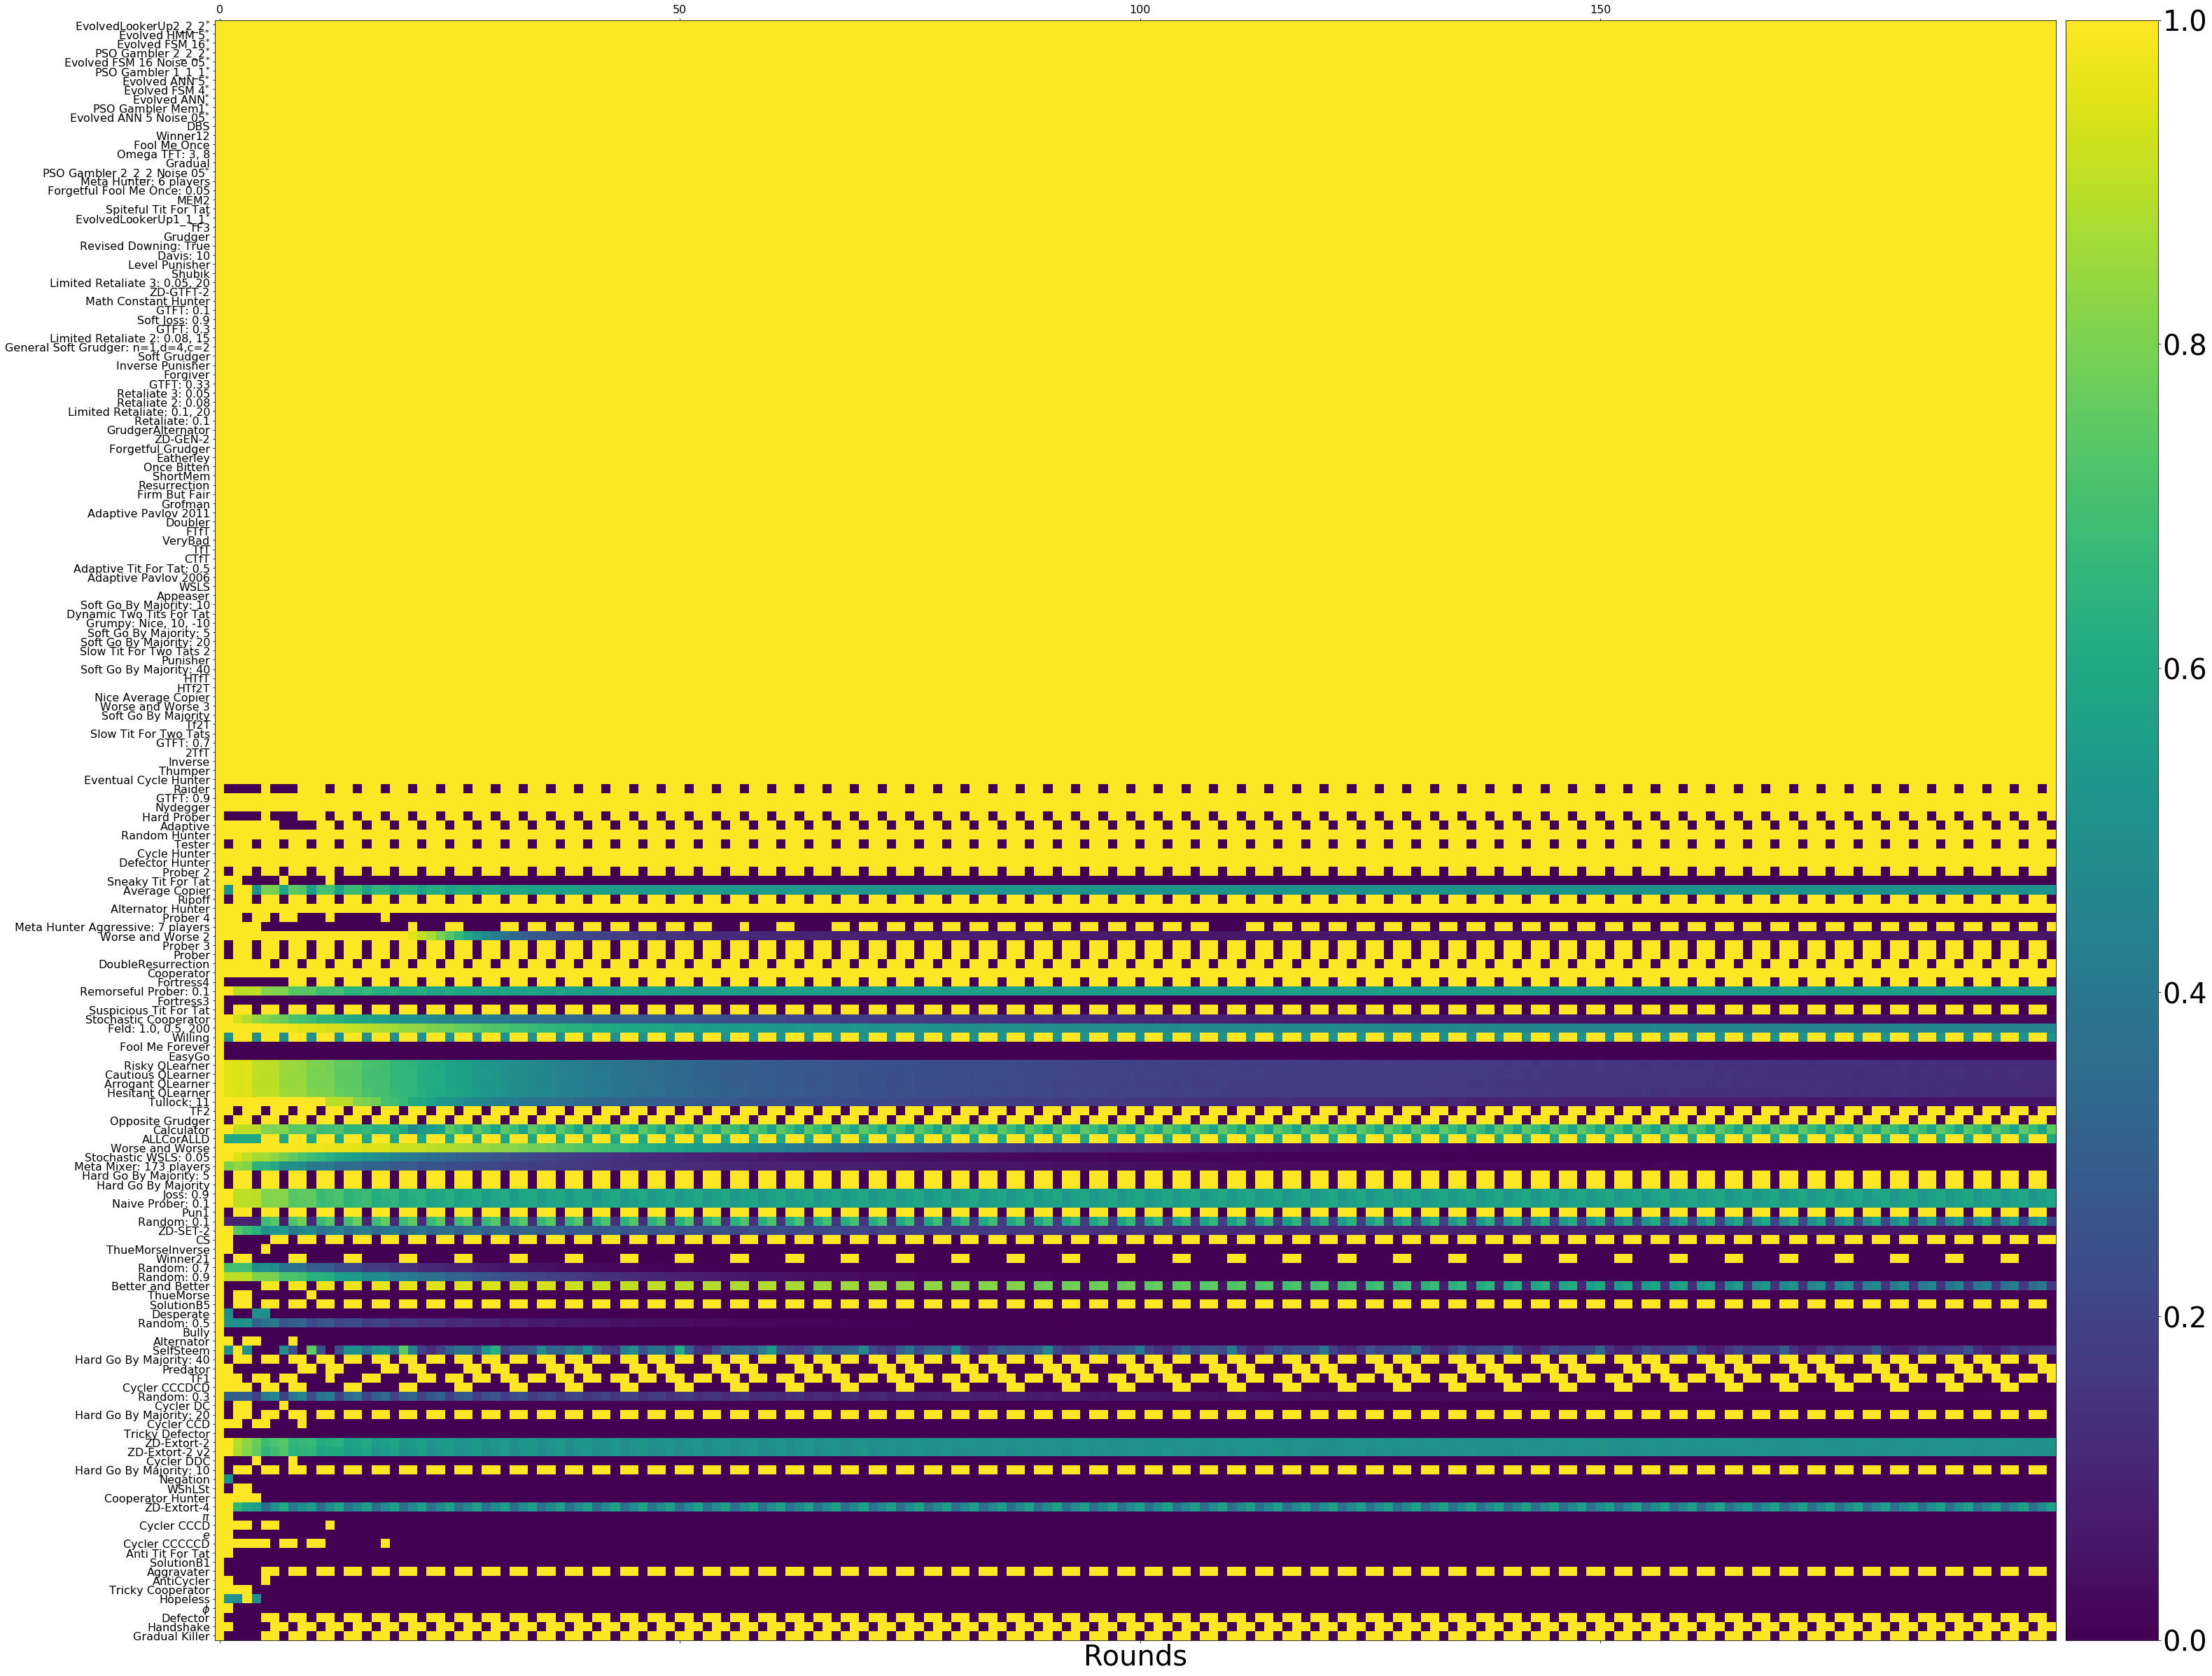

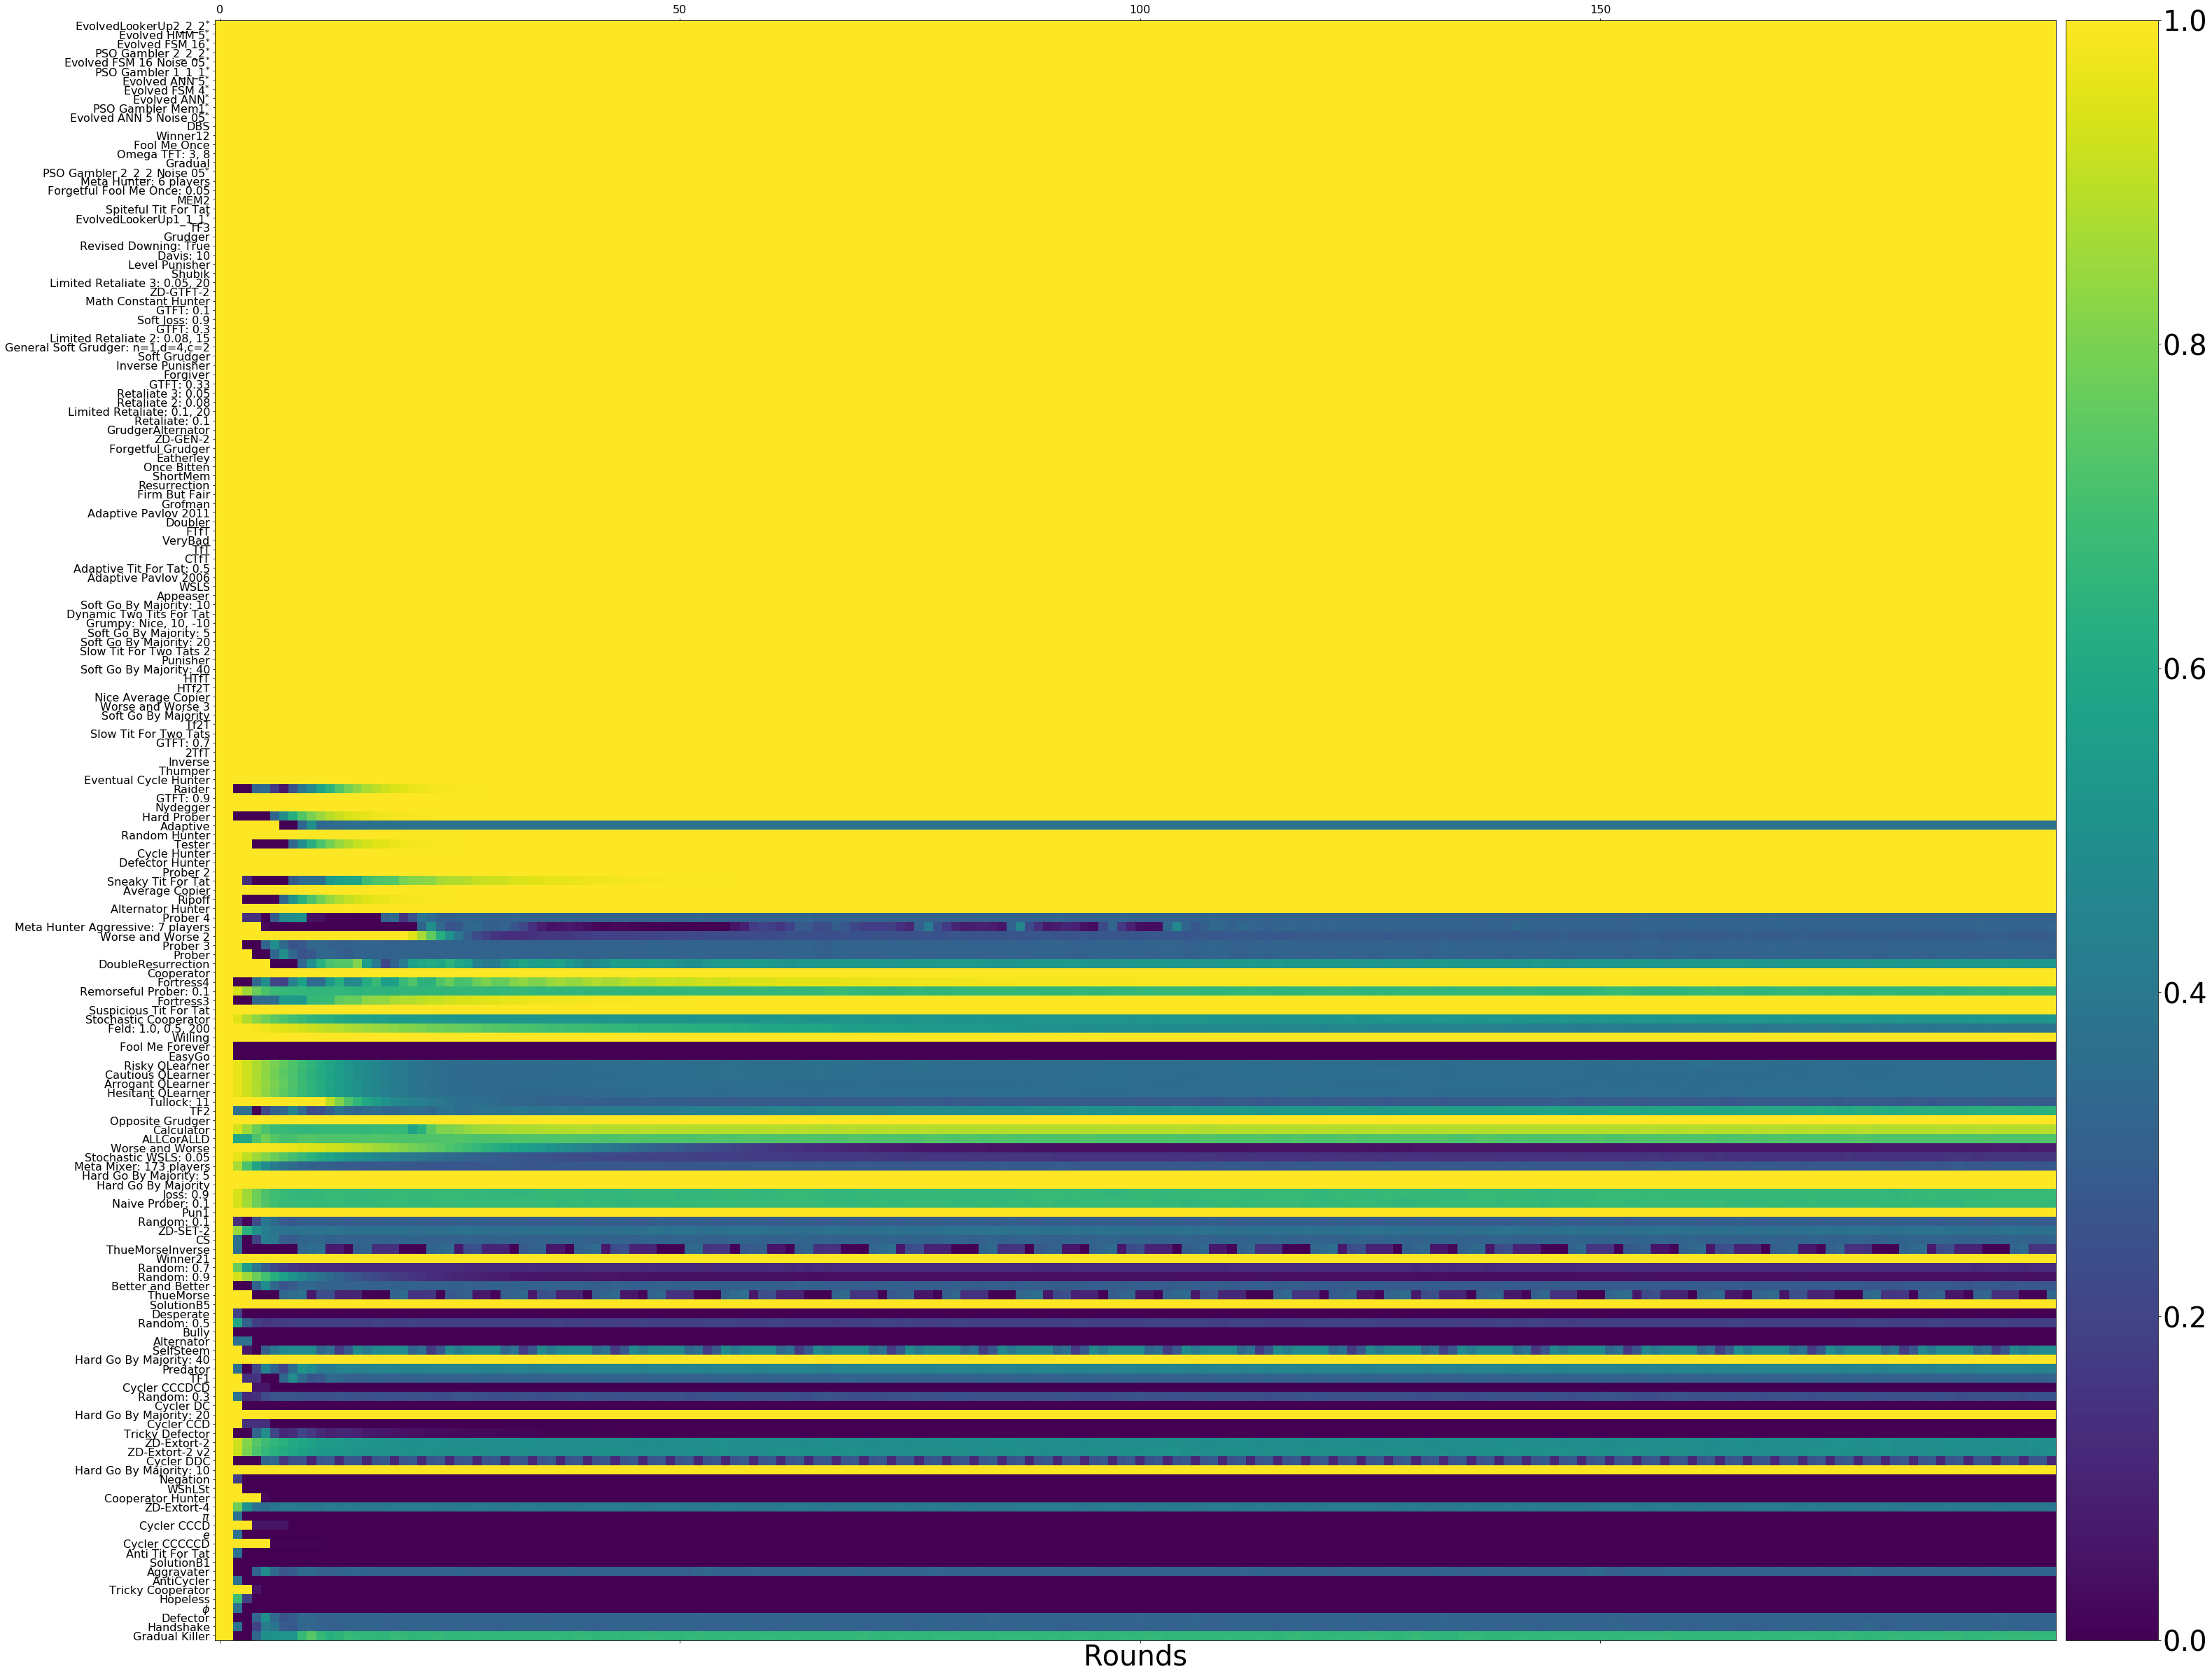

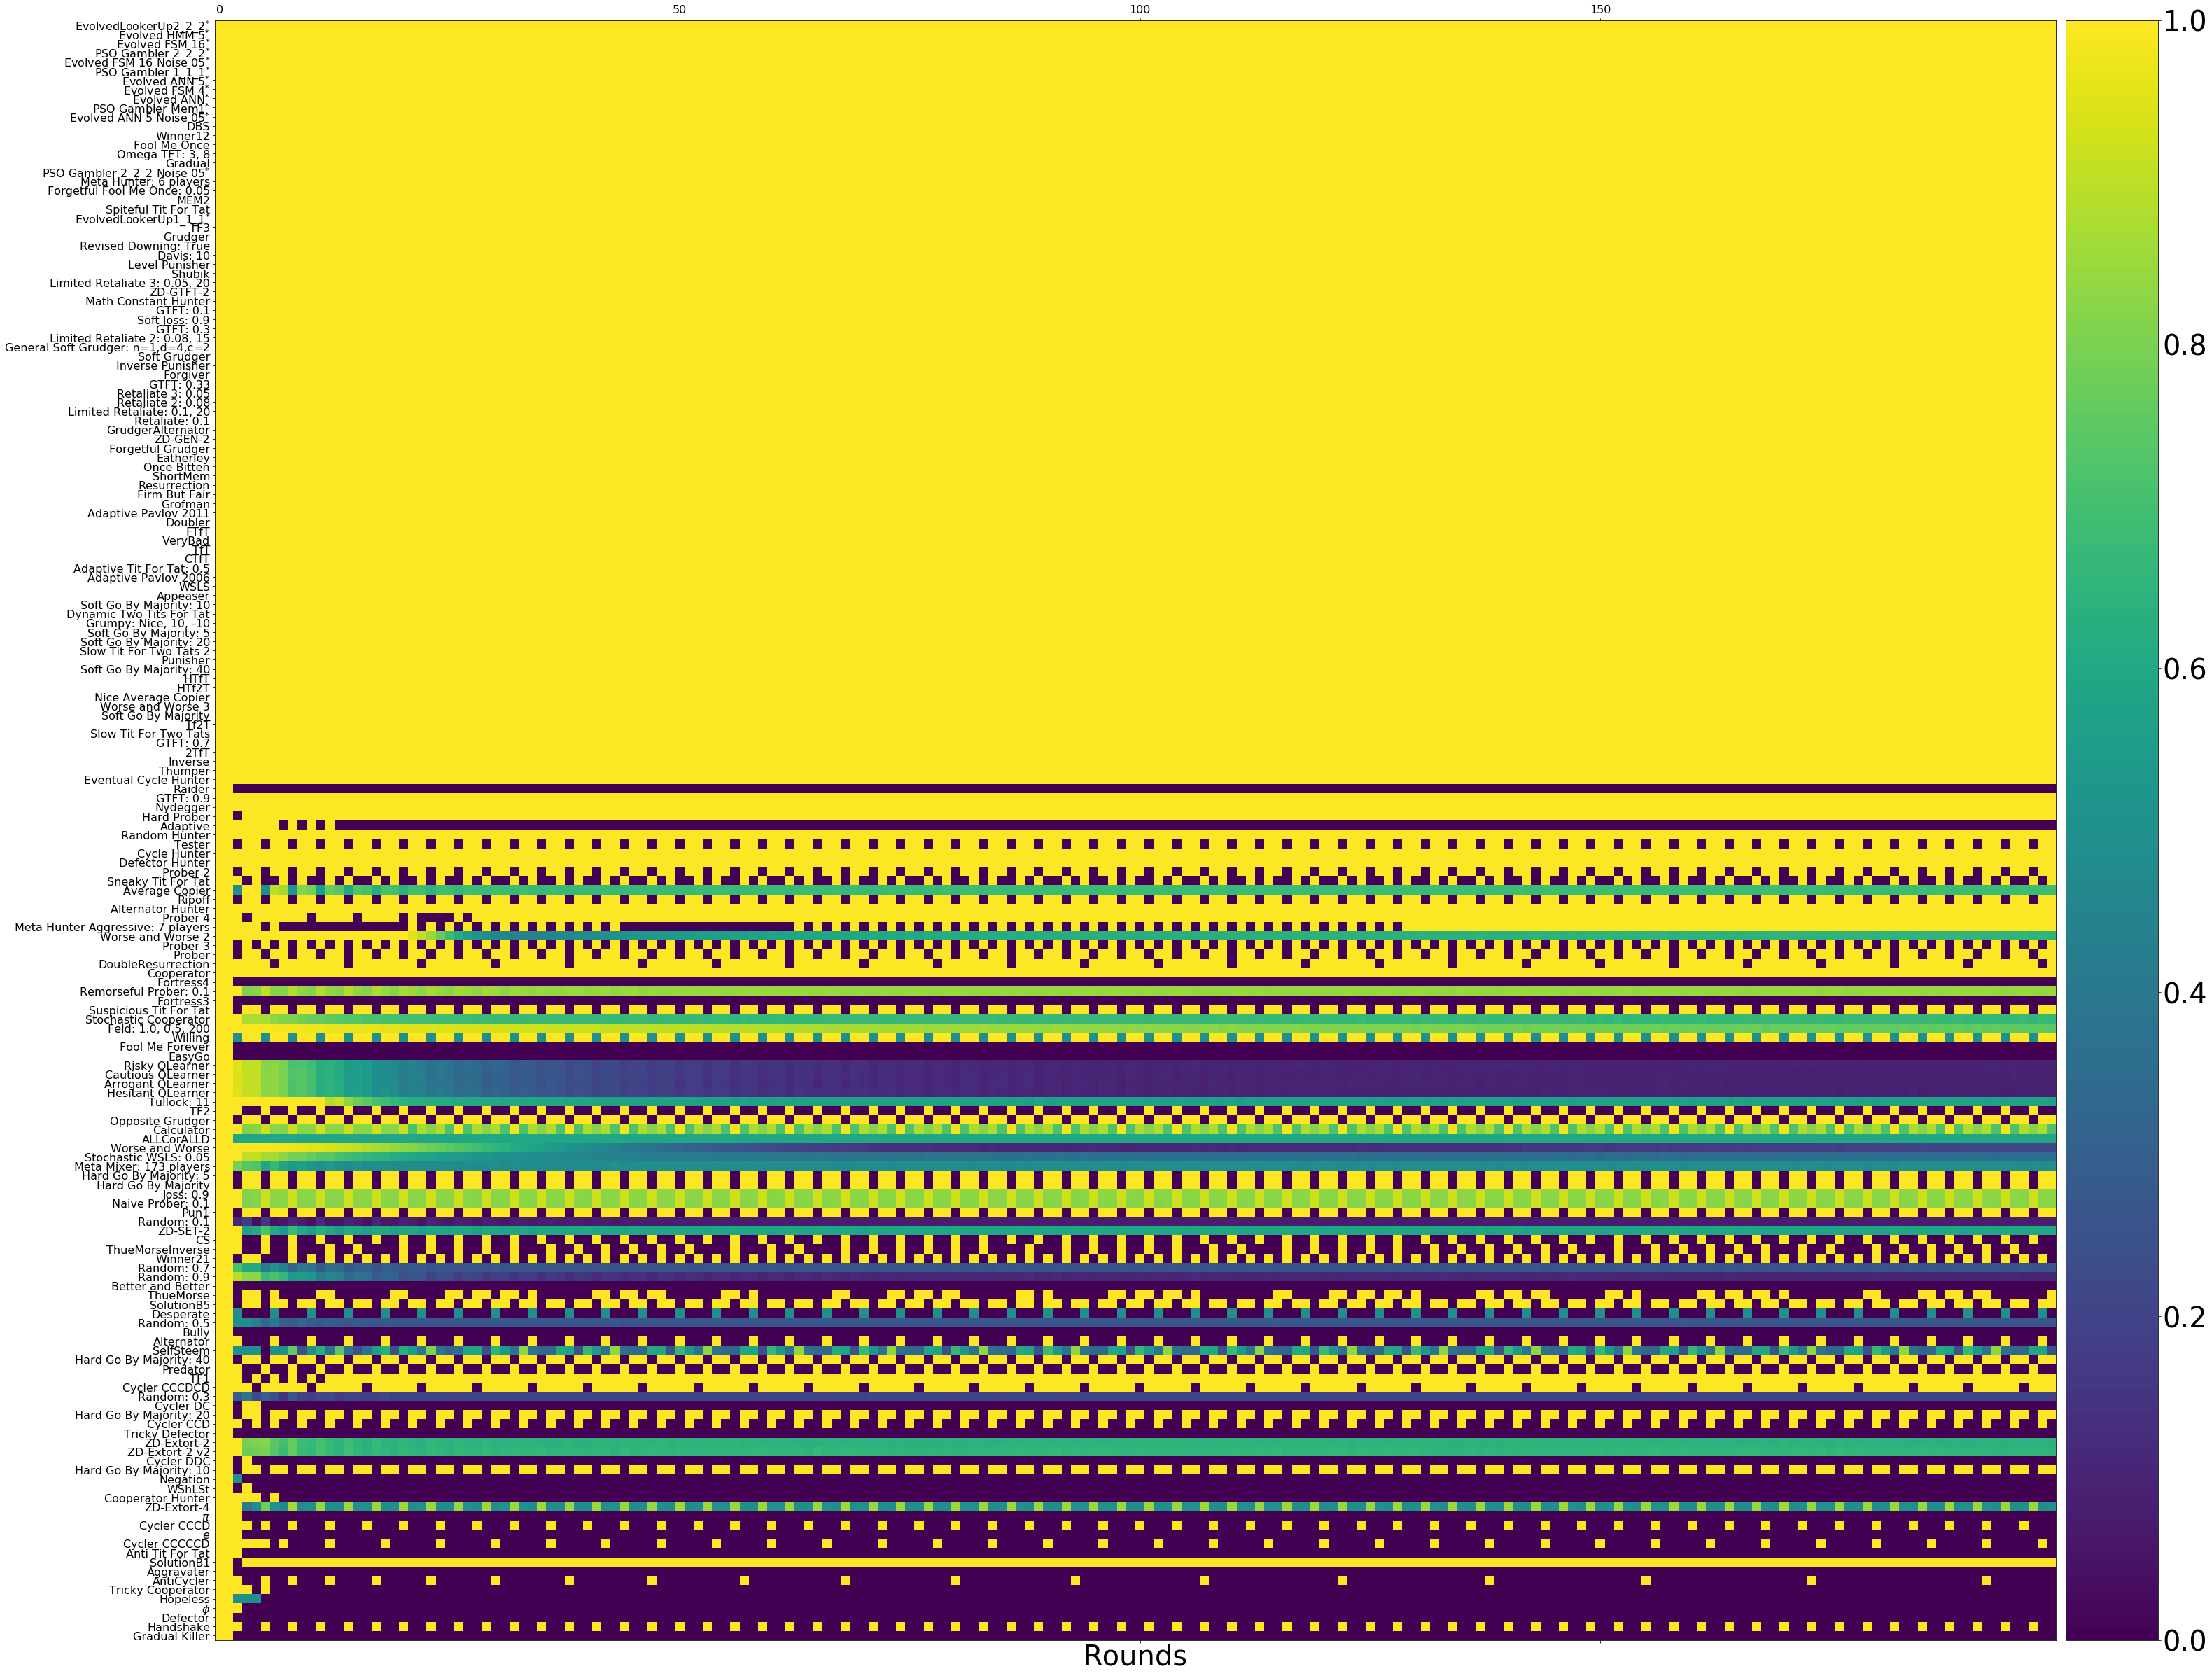

In [40]:
cooperation_files = glob.glob("./data/cooperation_*_array.gz")

for file in cooperation_files:
    cooperation_heatmap(file)

# Description of tournaments using Tit For Tat (for introduction).

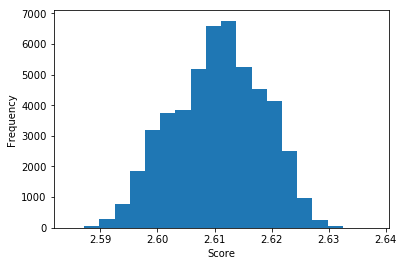

In [41]:
plt.figure()
plt.hist(standard_scores["TfT"], bins=20);
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.savefig("../assets/standard_tft_scores.pdf")

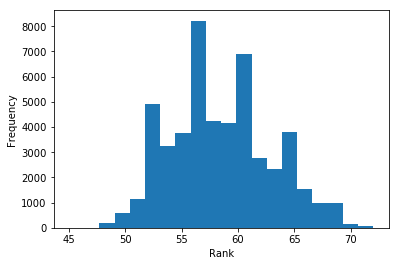

In [42]:
plt.figure()
plt.hist(standard_scores.rank(axis=1, ascending=False)["TfT"], bins=20)
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.savefig("../assets/standard_tft_ranks.pdf")

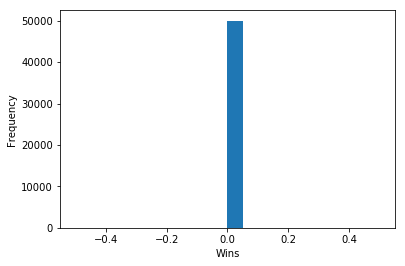

In [43]:
plt.figure()
plt.hist(standard_wins["TfT"], bins=20)
plt.xlabel("Wins")
plt.ylabel("Frequency")
plt.savefig("../assets/standard_tft_wins.pdf")